In [2]:
import re
import numpy as np
import pandas as pd
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import statsmodels.formula.api as smf
from pandas.api.types import CategoricalDtype
from scipy.stats import chi2, norm
from collections import defaultdict
from scipy.stats import pearsonr

**Calculate Mean and StD**

In [12]:
res = [0.877,
       0.9067,
       0.9406]

mean_res = np.mean(res)
std_res = np.std(res)

print(mean_res)
print(std_res)

0.9081
0.025983456275099348


**Get Mean Accuracies for different setups**

In [16]:
path = "vlcs_tta_results_all_domains_20250820_115337.txt"

with open(path, encoding="utf-8", errors="ignore") as f:
    lines = f.readlines()

records = []
current_domain, current_mode, current_seed, current_target = None, None, None, None
in_seed_block = False

re_domain   = re.compile(r"^=== TEST DOMAIN:\s+([A-Za-z0-9_]+)\s+===")
re_mode     = re.compile(r"^Mode:\s*([A-Z_0-9]+)\s*$")
re_seed     = re.compile(r"^Seed:\s*(\d+)\s*$")
re_target   = re.compile(r"^\s*Target\s+([A-Za-z0-9_]+):\s*$")
re_accuracy = re.compile(r"^\s*Accuracy:\s*([0-9]*\.[0-9]+)\s*$")

def norm_domain(d): return d.lower().replace("_", " ")
def norm_mode(m): return m.lower()

for line in lines:
    m = re_domain.match(line)
    if m:
        current_domain = norm_domain(m.group(1))
        continue
    m = re_mode.match(line)
    if m:
        current_mode = norm_mode(m.group(1))
        continue
    m = re_seed.match(line)
    if m:
        current_seed = int(m.group(1))
        in_seed_block = True
        continue
    if in_seed_block:
        mt = re_target.match(line)
        if mt:
            current_target = mt.group(1).lower()
            continue
        ma = re_accuracy.match(line)
        if ma and current_target is not None:
            acc = float(ma.group(1))
            records.append({
                "domain": current_domain,
                "mode": current_mode,
                "seed": current_seed,
                "target": current_target,
                "accuracy": acc,
            })

df = pd.DataFrame(records)

def mean_excl_original(group):
    vals = [v for t, v in zip(group["target"], group["accuracy"]) if t != "original"]
    return sum(vals)/len(vals) if vals else float("nan")

agg = (
    df.groupby(["domain","mode","seed"])
      .apply(lambda g: mean_excl_original(g.reset_index(drop=True)))
      .reset_index(name="mean_accuracy")
)

for _, row in agg.iterrows():
    print(f"{row['domain']}, {row['mode']}, seed {row['seed']}: {row['mean_accuracy']:}")


caltech101, average, seed 0: 0.6148
caltech101, average, seed 7: 0.6148
caltech101, average, seed 42: 0.6148
caltech101, selective_0_1, seed 0: 0.9644333333333334
caltech101, selective_0_1, seed 7: 0.9404
caltech101, selective_0_1, seed 42: 0.9686666666666667
caltech101, selective_0_2, seed 0: 0.8859666666666666
caltech101, selective_0_2, seed 7: 0.8379
caltech101, selective_0_2, seed 42: 0.9225
caltech101, selective_0_3, seed 0: 0.6148
caltech101, selective_0_3, seed 7: 0.43883333333333335
caltech101, selective_0_3, seed 42: 0.6148
caltech101, selective_1_2, seed 0: 0.8622
caltech101, selective_1_2, seed 7: 0.8158
caltech101, selective_1_2, seed 42: 0.9088333333333334
caltech101, selective_1_3, seed 0: 0.6148
caltech101, selective_1_3, seed 7: 0.43883333333333335
caltech101, selective_1_3, seed 42: 0.6148
caltech101, selective_2_3, seed 0: 0.6148
caltech101, selective_2_3, seed 7: 0.43883333333333335
caltech101, selective_2_3, seed 42: 0.6148
caltech101, single_0, seed 0: 0.9767
calte

/tmp/ipykernel_3388907/272447444.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mean_excl_original(g.reset_index(drop=True)))


In [5]:
FILE = Path("vlcs_tta_results_all_domains_20250820_115337.txt")

# %% Parser
test_pat = re.compile(r"^=== TEST DOMAIN:\s+([A-Za-z0-9_]+)\s+===")
mode_pat  = re.compile(r"^Mode:\s+([A-Z0-9_]+)")
seed_pat  = re.compile(r"^Seed:\s+(\d+)")
tgt_pat = re.compile(r"^\s*Target\s+([A-Za-z0-9_]+):\s*$")
acc_pat   = re.compile(r"^\s*Accuracy:\s*([0-9]*\.?[0-9]+)\s*$")

def normalize_domain(name):
    name = name.strip()
    name = name.lower()
    name = name.replace(" ", "_")
    return name

rows = []  # dict(test_domain, mode, seed, target_domain, acc)

cur_test = None
cur_mode = None
cur_seed = None
cur_target = None

with FILE.open("r", encoding="utf-8") as f:
    for line in f:
        line = line.rstrip("\n")

        m = test_pat.match(line)
        if m:
            cur_test = normalize_domain(m.group(1))
            cur_mode = None
            cur_seed = None
            cur_target = None
            continue

        m = mode_pat.match(line)
        if m:
            cur_mode = m.group(1).upper()  # f.e. SINGLE_0, SELECTIVE_0_1, AVERAGE
            cur_seed = None
            cur_target = None
            continue

        m = seed_pat.match(line)
        if m:
            cur_seed = int(m.group(1))
            cur_target = None
            continue

        m = tgt_pat.match(line)
        if m:
            cur_target = normalize_domain(m.group(1))
            continue

        m = acc_pat.match(line)
        if m and cur_test and cur_mode and cur_seed is not None and cur_target:
            acc = float(m.group(1))
            rows.append({
                "test_domain": cur_test,
                "mode": cur_mode,
                "seed": cur_seed,
                "target_domain": cur_target,
                "accuracy": acc
            })
            continue

df = pd.DataFrame(rows)

df_no_orig = df[df["target_domain"] != "original"].copy()

agg = (
    df_no_orig
    .groupby(["test_domain", "mode", "target_domain"], as_index=False)
    .agg(mean_acc=("accuracy", "mean"),
         std_acc =("accuracy", "std"),
         n_seeds=("accuracy", "size"))
)

#domain_order = ["art_painting", "cartoon", "photo", "sketch"]
domain_order = ["caltech101", "labelme", "sun09", "voc2007"]

agg["test_domain"] = pd.Categorical(agg["test_domain"], domain_order, ordered=True)
agg["target_domain"] = pd.Categorical(agg["target_domain"], domain_order, ordered=True)
agg = agg.sort_values(["test_domain", "mode", "target_domain"]).reset_index(drop=True)

print("tidy table (one row per test_domain / mode / target_domain):")
display(agg)

def fmt(mean, std):
    if pd.isna(std):
        return f"{mean:.4f} ± nan"
    return f"{mean:.4f} ± {std:.4f}"

pivot = (
    agg
    .assign(mean_std=agg.apply(lambda r: fmt(r["mean_acc"], r["std_acc"]), axis=1))
    .pivot_table(index=["test_domain", "mode"], columns="target_domain", values="mean_std", aggfunc="first")
    .reindex(columns=[d for d in domain_order if d in agg["target_domain"].unique()])
    .sort_index()
)

print("\nPivot (mean ± std):")
display(pivot)

tidy table (one row per test_domain / mode / target_domain):


,test_domain,mode,target_domain,mean_acc,std_acc,n_seeds
0,caltech101,AVERAGE,labelme,0.614800,0.000000,3
1,caltech101,AVERAGE,sun09,0.614800,0.000000,3
2,caltech101,AVERAGE,voc2007,0.614800,0.000000,3
3,caltech101,SELECTIVE_0_1,labelme,0.957100,0.016074,3
4,caltech101,SELECTIVE_0_1,sun09,0.956433,0.017381,3
...,...,...,...,...,...,...
127,voc2007,SINGLE_2,labelme,0.663500,0.063876,3
128,voc2007,SINGLE_2,sun09,0.709033,0.016929,3
129,voc2007,SINGLE_3,caltech101,0.444000,0.000000,3
130,voc2007,SINGLE_3,labelme,0.286000,0.136832,3



Pivot (mean ± std):


/tmp/ipykernel_3396556/1854754316.py:93: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  agg


target_domain                   caltech101          labelme            sun09  \
test_domain mode                                                               
caltech101  AVERAGE                    NaN  0.6148 ± 0.0000  0.6148 ± 0.0000   
            SELECTIVE_0_1              NaN  0.9571 ± 0.0161  0.9564 ± 0.0174   
            SELECTIVE_0_2              NaN  0.8582 ± 0.0481  0.8850 ± 0.0460   
            SELECTIVE_0_3              NaN  0.4388 ± 0.3048  0.6148 ± 0.0000   
            SELECTIVE_1_2              NaN  0.8349 ± 0.0582  0.8565 ± 0.0509   
            SELECTIVE_1_3              NaN  0.4388 ± 0.3048  0.6148 ± 0.0000   
            SELECTIVE_2_3              NaN  0.4388 ± 0.3048  0.6148 ± 0.0000   
            SINGLE_0                   NaN  0.9774 ± 0.0056  0.9750 ± 0.0057   
            SINGLE_1                   NaN  0.9628 ± 0.0138  0.9656 ± 0.0134   
            SINGLE_2                   NaN  0.8758 ± 0.0456  0.9008 ± 0.0402   
            SINGLE_3                   NaN  0.4388 ± 0.3048  0.6148 ± 0.0000   
labelme     AVERAGE        0.4657 ± 0.0000              NaN  0.4657 ± 0.0000   
            SELECTIVE_0_1  0.6324 ± 0.0008              NaN  0.6207 ± 0.0014   
            SELECTIVE_0_2  0.6215 ± 0.0167              NaN  0.5901 ± 0.0272   
            SELECTIVE_0_3  0.4657 ± 0.0000              NaN  0.4657 ± 0.0000   
            SELECTIVE_1_2  0.6277 ± 0.0163              NaN  0.5906 ± 0.0281   
            SELECTIVE_1_3  0.4657 ± 0.0000              NaN  0.4657 ± 0.0000   
            SELECTIVE_2_3  0.4657 ± 0.0000              NaN  0.4657 ± 0.0000   
            SINGLE_0       0.6276 ± 0.0025              NaN  0.6287 ± 0.0025   
            SINGLE_1       0.6393 ± 0.0047              NaN  0.6272 ± 0.0025   
            SINGLE_2       0.6375 ± 0.0166              NaN  0.6101 ± 0.0241   
            SINGLE_3       0.4657 ± 0.0000              NaN  0.4657 ± 0.0000   
sun09       AVERAGE        0.3851 ± 0.0000  0.3851 ± 0.0000              NaN   
            SELECTIVE_0_1  0.6922 ± 0.0041  0.6969 ± 0.0093              NaN   
            SELECTIVE_0_2  0.5586 ± 0.0488  0.5750 ± 0.0034              NaN   
            SELECTIVE_0_3  0.3851 ± 0.0000  0.2840 ± 0.0000              NaN   
            SELECTIVE_1_2  0.5433 ± 0.0463  0.5693 ± 0.0058              NaN   
            SELECTIVE_1_3  0.3851 ± 0.0000  0.2840 ± 0.0000              NaN   
            SELECTIVE_2_3  0.3851 ± 0.0000  0.2840 ± 0.0000              NaN   
            SINGLE_0       0.6979 ± 0.0138  0.7035 ± 0.0153              NaN   
            SINGLE_1       0.6984 ± 0.0052  0.7048 ± 0.0120              NaN   
            SINGLE_2       0.5951 ± 0.0489  0.5798 ± 0.0013              NaN   
            SINGLE_3       0.3851 ± 0.0000  0.2840 ± 0.0000              NaN   
voc2007     AVERAGE        0.4440 ± 0.0000  0.4440 ± 0.0000  0.4440 ± 0.0000   
            SELECTIVE_0_1  0.7695 ± 0.0082  0.7669 ± 0.0079  0.7571 ± 0.0093   
            SELECTIVE_0_2  0.7035 ± 0.0369  0.6384 ± 0.0588  0.6910 ± 0.0097   
            SELECTIVE_0_3  0.4440 ± 0.0000  0.2860 ± 0.1368  0.4440 ± 0.0000   
            SELECTIVE_1_2  0.6932 ± 0.0386  0.6286 ± 0.0572  0.6787 ± 0.0096   
            SELECTIVE_1_3  0.4440 ± 0.0000  0.2860 ± 0.1368  0.4440 ± 0.0000   
            SELECTIVE_2_3  0.4440 ± 0.0000  0.2860 ± 0.1368  0.4440 ± 0.0000   
            SINGLE_0       0.7730 ± 0.0106  0.7690 ± 0.0056  0.7687 ± 0.0071   
            SINGLE_1       0.7770 ± 0.0085  0.7703 ± 0.0086  0.7650 ± 0.0088   
            SINGLE_2       0.7292 ± 0.0352  0.6635 ± 0.0639  0.7090 ± 0.0169   
            SINGLE_3       0.4440 ± 0.0000  0.2860 ± 0.1368  0.4440 ± 0.0000   

target_domain                      voc2007  
test_domain mode                            
caltech101  AVERAGE        0.6148 ± 0.0000  
            SELECTIVE_0_1  0.9600 ± 0.0125  
            SELECTIVE_0_2  0.9032 ± 0.0336  
            SELECTIVE_0_3  0.6148 ± 0.0000  
            SELECTIVE_1_2  0.8954 ± 0.0315  
    

**EXPERIMENT: Linear Mixed Model for Statistical Evaluation**

In [4]:
df = pd.read_csv("pacs_results.csv")

df = df.rename(columns={
    "domain": "domain",
    "seed": "seed",
    "approach": "approach",
    "mode": "mode",
    "mean accuracy": "accuracy"
})
df["accuracy"] = pd.to_numeric(df["accuracy"], errors="coerce")
df = df.dropna(subset=["accuracy", "domain", "seed", "approach", "mode"]).copy()

# categories
df["approach"] = pd.Categorical(df["approach"], categories=["MixStyle", "TTA"])
df.loc[df["approach"] == "MixStyle", "mode"] = "base"
df["mode"] = pd.Categorical(df["mode"])

# domain × seed id for random effects
df["domain_seed"] = df["domain"].astype(str) + "_" + df["seed"].astype(str)

# ----------------------
# 1) TTA-only
# ----------------------
df_tta = df[df["approach"] == "TTA"].copy()
df_tta["mode"] = df_tta["mode"].cat.remove_unused_categories()

vc_tta = {"seed": "0 + C(domain_seed)"}
model_tta = smf.mixedlm(
    "accuracy ~ C(mode)",
    data=df_tta,
    groups=df_tta["domain"],
    vc_formula=vc_tta
)
res_tta = model_tta.fit(method="lbfgs", reml=False, maxiter=200)
print("\n=== TTA-only: Mode-Effekte ===")
print(res_tta.summary())

# ----------------------
# 2) MixStyle (base) vs TTA modes
# ----------------------
best_modes = ["single_0", "single_1", "selective_0_1"]

df_compare = df[
    ((df["approach"] == "MixStyle") & (df["mode"] == "base"))
    | ((df["approach"] == "TTA") & (df["mode"].isin(best_modes)))
].copy()

df_compare["mode"] = pd.Categorical(
    df_compare["mode"],
    categories=["base"] + [m for m in best_modes if m in df_compare["mode"].unique()]
)

vc_compare = {"seed": "0 + C(domain_seed)"}

model_compare = smf.mixedlm(
    "accuracy ~ C(mode, Treatment(reference='base'))",
    data=df_compare,
    groups=df_compare["domain"],
    vc_formula=vc_compare
)

try:
    res_compare = model_compare.fit(method="lbfgs", reml=False, maxiter=200)
except Exception:
    model_compare_simple = smf.mixedlm(
        "accuracy ~ C(mode, Treatment(reference='base'))",
        data=df_compare,
        groups=df_compare["domain"]
    )
    res_compare = model_compare_simple.fit(method="lbfgs", reml=False, maxiter=200)

print("\n=== MixStyle (base) vs. einzelne TTA-Modi ===")
print(res_compare.summary())

# ----------------------
# 3) Effekt-Tabelle extrahieren
# ----------------------
def fixed_effects_table(res):
    ci = res.conf_int()
    return pd.DataFrame({
        "coef": res.params,
        "ci_low": ci[0],
        "ci_high": ci[1]
    })

print("\nFixed Effects (TTA-only):\n", fixed_effects_table(res_tta))
print("\nFixed Effects (MixStyle vs. beste TTA):\n", fixed_effects_table(res_compare))

# ----------------------
# 4) MixStyle (base) vs domain x mode
# ----------------------

modes_available = [m for m in df_compare["mode"].cat.categories if m != "base"]

# Wide-Table: Zeilen = (domain, seed), Spalten = mode, Werte = accuracy
wide = (
    df_compare.pivot_table(index=["domain", "seed"], columns="mode", values="accuracy", aggfunc="mean")
    .reindex(columns=["base"] + modes_available)
)

results = []
for dom in wide.index.get_level_values("domain").unique():
    sub = wide.loc[dom]  # DataFrame: index=seed, cols=base + modes
    for mode in modes_available:
        diffs = (sub[mode] - sub["base"]).dropna()  # nur Seeds mit beiden Werten
        n = diffs.shape[0]
        if n == 0:
            mean_diff = np.nan
            sd = se = ci_low = ci_high = np.nan
        else:
            mean_diff = diffs.mean()
            sd = diffs.std(ddof=1) if n > 1 else 0.0
            se = sd / np.sqrt(n) if n > 1 else 0.0
            # 95%-CI mit t-Verteilung (bei n=1 kein CI sinnvoll)
            if n > 1:
                t_crit = stats.t.ppf(0.975, df=n-1)
                ci_low = mean_diff - t_crit * se
                ci_high = mean_diff + t_crit * se
            else:
                ci_low = ci_high = np.nan

        results.append({
            "domain": dom,
            "mode": mode,
            "n_seed_pairs": n,
            "mean_improvement_over_base": mean_diff,
            "sd_diff": sd,
            "se_diff": se,
            "ci95_low": ci_low,
            "ci95_high": ci_high,
        })

improvement_table = pd.DataFrame(results).sort_values(["domain", "mode"]).reset_index(drop=True)
print("\n=== Domänen × Modus: Verbesserung ggü. base (gepaart pro Seed) ===")
print(improvement_table)



=== TTA-only: Mode-Effekte ===
              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     accuracy
No. Observations:     132         Method:                 ML      
No. Groups:           4           Scale:                  0.0021  
Min. group size:      33          Log-Likelihood:         188.1686
Max. group size:      33          Converged:              Yes     
Mean group size:      33.0                                        
------------------------------------------------------------------
                         Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.134    0.055  2.450 0.014  0.027  0.241
C(mode)[T.selective_0_1] 0.715    0.019 38.083 0.000  0.678  0.752
C(mode)[T.selective_0_2] 0.694    0.019 36.972 0.000  0.657  0.731
C(mode)[T.selective_0_3] 0.007    0.019  0.382 0.702 -0.030  0.044
C(mode)[T.selective_1_2] 0.692    0.019 36.86

/home/hahlers/miniconda3/envs/server_env/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1533: RuntimeWarning: divide by zero encountered in log
  cov_aug_logdet = cov_re_logdet + np.sum(np.log(vc_var))
/home/hahlers/miniconda3/envs/server_env/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1537: RuntimeWarning: divide by zero encountered in divide
  solver = _smw_solver(1., ex_r, ex2_r, cov_re_inv, 1 / vc_var)
/home/hahlers/miniconda3/envs/server_env/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1542: RuntimeWarning: divide by zero encountered in divide
  ld = _smw_logdet(1., ex_r, ex2_r, cov_re_inv, 1 / vc_var,
/home/hahlers/miniconda3/envs/server_env/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:573: RuntimeWarning: invalid value encountered in scalar add
  return B_logdet + ld + ld1
/home/hahlers/miniconda3/envs/server_env/lib/python3.10/site-packages/statsmodels/regression/m

**paired t-test**

In [4]:
# 1) Daten für MixStyle und single_1
df_pair = df[df["mode"].isin(["base", "single_1"])].copy()

# 2) Mittelwert pro Domäne & Modus (Seeds aggregieren)
df_mean = df_pair.groupby(["domain", "mode"], observed=True)["accuracy"].mean().unstack("mode")

# 3) Paired t-Test (Differenz pro Domäne: single_1 - base)
t_stat, p_val = stats.ttest_rel(df_mean["single_1"], df_mean["base"])

print("=== Paired t-Test: MixStyle (base) vs. TTA (single_1) ===")
print("t-Statistic:", t_stat)
print("p-Value:", p_val)
print("\nMean Accuracy (over seeds):")
print(df_mean)
print("\nMean Difference (single_1 - base):", (df_mean["single_1"] - df_mean["base"]).mean())


=== Paired t-Test: MixStyle (base) vs. TTA (single_1) ===
t-Statistic: -1.1724386859898208
p-Value: 0.3256505737153177

Mean Accuracy (over seeds):
mode            base  single_1
domain                        
Caltech101  0.977145  0.965067
LabelMe     0.648690  0.637889
SUN09       0.721142  0.701300
VOC2007     0.759445  0.770767

Mean Difference (single_1 - base): -0.007849908439288983


**Visualizations**

In [10]:
FILE_PATH = "pacs_tta_results_all_domains_20250820_115822.txt"

text = Path(FILE_PATH).read_text(encoding="utf-8", errors="ignore")

domain_header_re = re.compile(r"^=== TEST DOMAIN:\s*(.+?)\s*===", re.MULTILINE)
mode_re = re.compile(r"^Mode:\s*(.+?)\s*$", re.MULTILINE)
seed_re = re.compile(r"^Seed:\s*(\d+)\s*$", re.MULTILINE)

cross_var_re = re.compile(r"Mean cross-domain variance:\s*([0-9.]+)")
cross_dis_re = re.compile(r"Mean cross-domain disagreement:\s*([0-9.]+)")
real_var_re = re.compile(r"Mean real class variance:\s*([0-9.]+)")

mean_acc_re = re.compile(
    r"Mean accuracy across seeds \(target domains only\):\s*([0-9.]+)"
)

domain_splits = list(domain_header_re.finditer(text))

# Datencontainer
# metrics[(domain, mode)]['seeds'] -> Liste von dicts mit den drei Stability-Metriken
# metrics[(domain, mode)]['mean_accuracy'] -> float (aus der Mode-Zusammenfassung)
metrics = defaultdict(lambda: {"seeds": [], "mean_accuracy": None})

for i, m in enumerate(domain_splits):
    domain = m.group(1).strip()
    start = m.end()
    end = domain_splits[i + 1].start() if i + 1 < len(domain_splits) else len(text)
    domain_block = text[start:end]

    # Finde alle Modes im Domain-Block
    mode_iter = list(mode_re.finditer(domain_block))
    for j, mm in enumerate(mode_iter):
        mode_name = mm.group(1).strip()
        m_start = mm.end()
        m_end = mode_iter[j + 1].start() if j + 1 < len(mode_iter) else len(domain_block)
        mode_block = domain_block[m_start:m_end]

        # Alle Seed-Abschnitte im Mode-Block finden
        seed_iter = list(seed_re.finditer(mode_block))
        for k, sm in enumerate(seed_iter):
            s_start = sm.end()
            s_end = seed_iter[k + 1].start() if k + 1 < len(seed_iter) else len(mode_block)
            seed_block = mode_block[s_start:s_end]

            # Cross-domain summary Metriken
            cv = cross_var_re.search(seed_block)
            cd = cross_dis_re.search(seed_block)
            rv = real_var_re.search(seed_block)

            # Nur wenn alle drei gefunden wurden, übernehmen
            if cv and cd and rv:
                metrics[(domain, mode_name)]["seeds"].append(
                    {
                        "seed": int(sm.group(1)),
                        "cross_domain_variance": float(cv.group(1)),
                        "cross_domain_disagreement": float(cd.group(1)),
                        "real_class_variance": float(rv.group(1)),
                    }
                )

        # Mean accuracy across seeds (target domains only)
        ma = mean_acc_re.search(mode_block)
        if ma:
            metrics[(domain, mode_name)]["mean_accuracy"] = float(ma.group(1))

# -------------------------------------------------------
# Aggregation über Seeds
# -------------------------------------------------------
import pandas as pd

rows = []
for (domain, mode), vals in metrics.items():
    seeds = vals["seeds"]
    if len(seeds) == 0:
        # Falls keine Seeds geparst wurden, überspringen
        continue
    cross_domain_variance_mean = np.mean([s["cross_domain_variance"] for s in seeds])
    cross_domain_dis_mean = np.mean([s["cross_domain_disagreement"] for s in seeds])
    real_class_variance_mean = np.mean([s["real_class_variance"] for s in seeds])
    acc = vals["mean_accuracy"]  # kann None sein, wenn im File nicht vorhanden

    rows.append(
        {
            "test_domain": domain,
            "mode": mode,
            "mean_cross_domain_variance": cross_domain_variance_mean,
            "mean_cross_domain_disagreement": cross_domain_dis_mean,
            "mean_real_class_variance": real_class_variance_mean,
            "mean_accuracy": acc,
            "num_seeds": len(seeds),
        }
    )

df = pd.DataFrame(rows)

seed_rows = []
for (domain, mode), vals in metrics.items():
    for s in vals["seeds"]:
        seed_rows.append({
            "test_domain": domain,
            "mode": mode,
            "seed": s.get("seed", None),
            "cross_domain_variance": s["cross_domain_variance"],
            "cross_domain_disagreement": s["cross_domain_disagreement"],
            "real_class_variance": s["real_class_variance"],
        })

seed_df = pd.DataFrame(seed_rows)

# konsistente Domain-Reihenfolge
seed_df["test_domain"] = pd.Categorical(seed_df["test_domain"], domain_order, ordered=True)

def mode_sort_key(m):
    # versucht numerische Teile ans Ende zu hängen (z.B. SINGLE_0 < SINGLE_1 < ... < AVERAGE)
    parts = re.split(r"[_\-]", m)
    key = []
    for p in parts:
        key.append((0, int(p)) if p.isdigit() else (1, p))
    return key

def get_vmin_vmax(series, pad=0.0):
    vmin = series.min()
    vmax = series.max()
    if pad:
        rng = vmax - vmin
        vmin -= pad * rng
        vmax += pad * rng
    return float(vmin), float(vmax)

# Sinnvolle Reihenfolge der Testdomains (PACS):
domain_order = ["ART_PAINTING", "CARTOON", "PHOTO", "SKETCH"]
#domain_order = ["Caltech101", "LabelMe", "SUN09", "VOC2007"]
df["test_domain"] = pd.Categorical(df["test_domain"], domain_order, ordered=True)


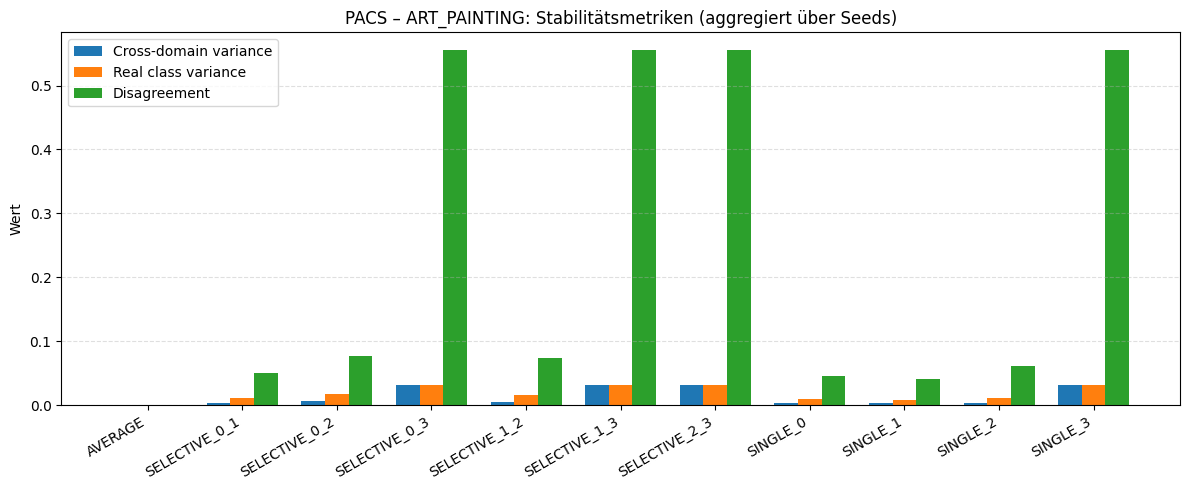

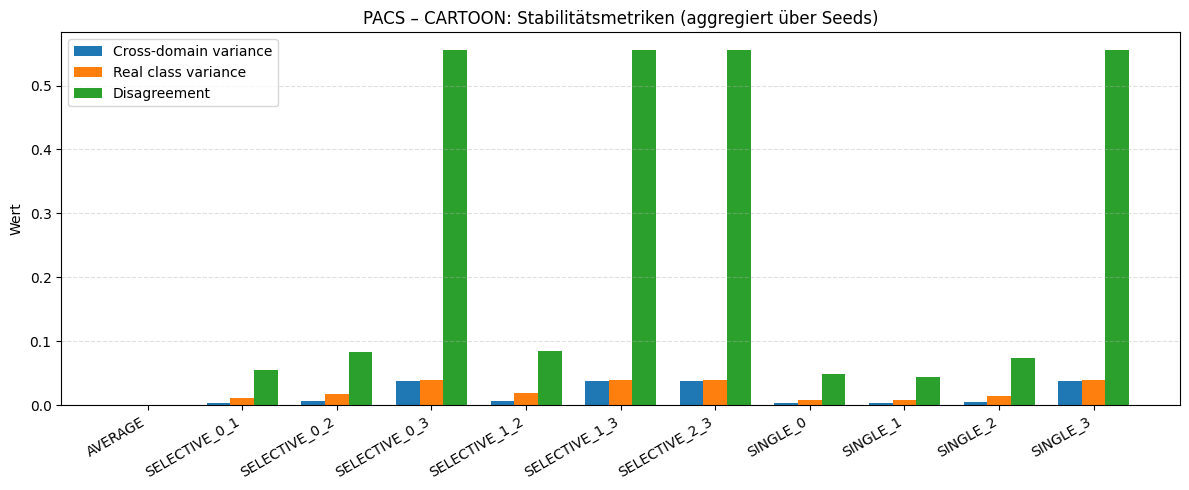

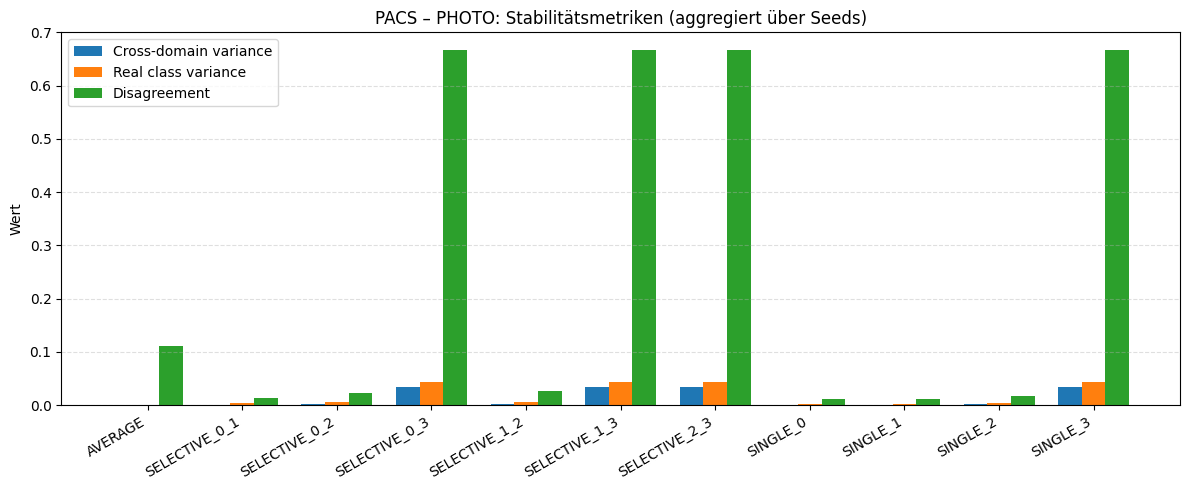

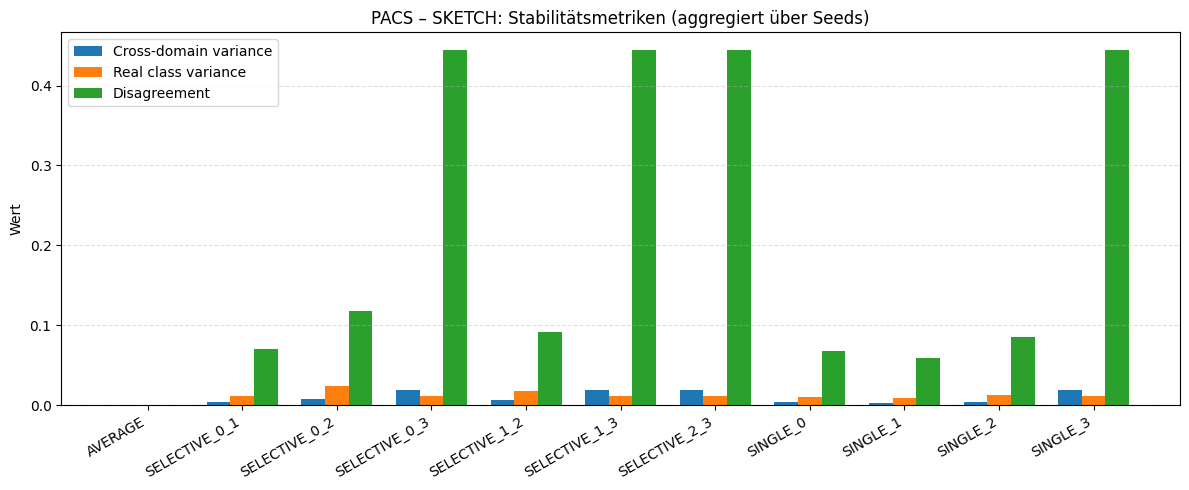

In [6]:
def plot_bars_by_domain(df_domain, domain_name):
    # Sortiere Modi
    df_domain = df_domain.sort_values(by="mode", key=lambda s: s.map(mode_sort_key))

    modes = df_domain["mode"].tolist()
    x = np.arange(len(modes))

    width = 0.25
    fig, ax = plt.subplots(figsize=(12, 5))
    # Drei Metriken nebeneinander
    ax.bar(
        x - width,
        df_domain["mean_cross_domain_variance"].values,
        width,
        label="Cross-domain variance",
    )
    ax.bar(
        x,
        df_domain["mean_real_class_variance"].values,
        width,
        label="Real class variance",
    )
    ax.bar(
        x + width,
        df_domain["mean_cross_domain_disagreement"].values,
        width,
        label="Disagreement",
    )

    ax.set_title(f"PACS – {domain_name}: Stabilitätsmetriken (aggregiert über Seeds)")
    ax.set_xticks(x)
    ax.set_xticklabels(modes, rotation=30, ha="right")
    ax.set_ylabel("Wert")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# Erzeuge Balkendiagramme je Domain
for dom in df["test_domain"].cat.categories:
    sub = df[df["test_domain"] == dom]
    if len(sub) > 0:
        plot_bars_by_domain(sub, dom)

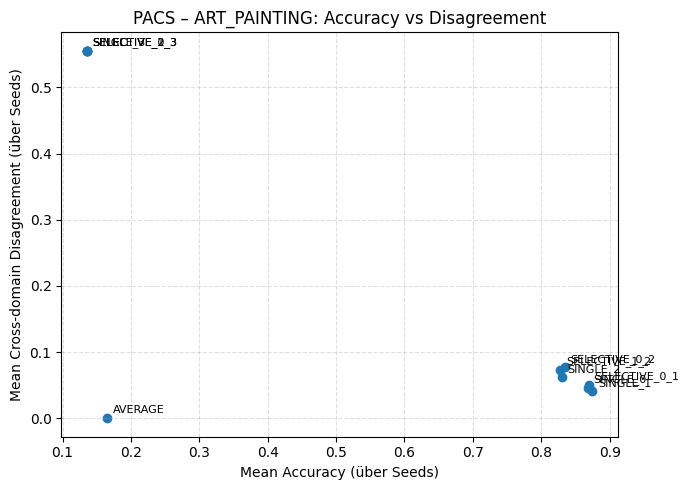

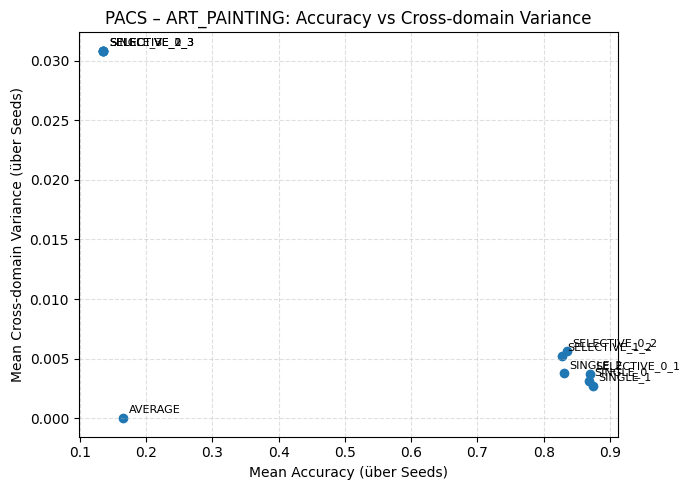

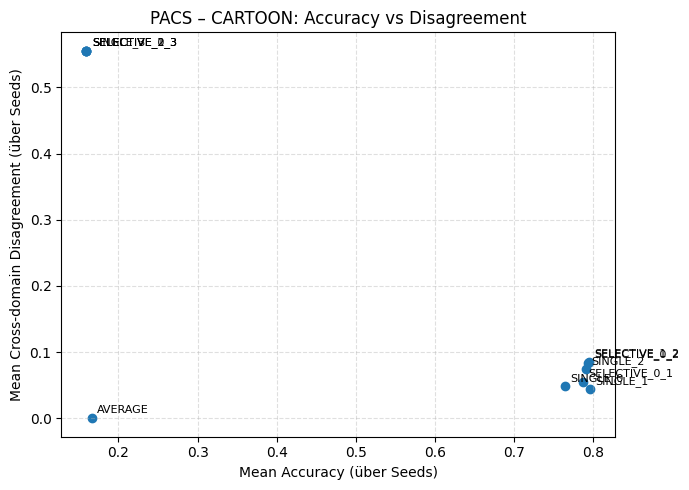

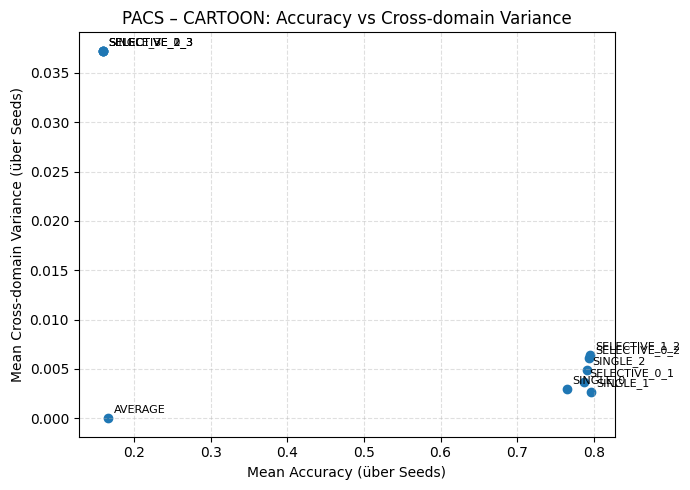

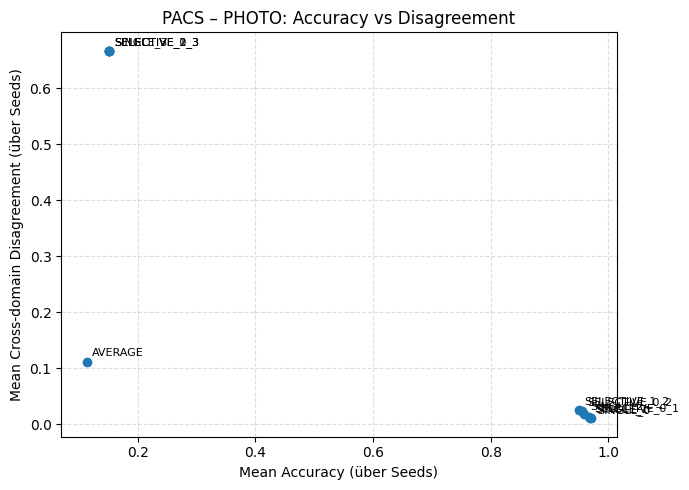

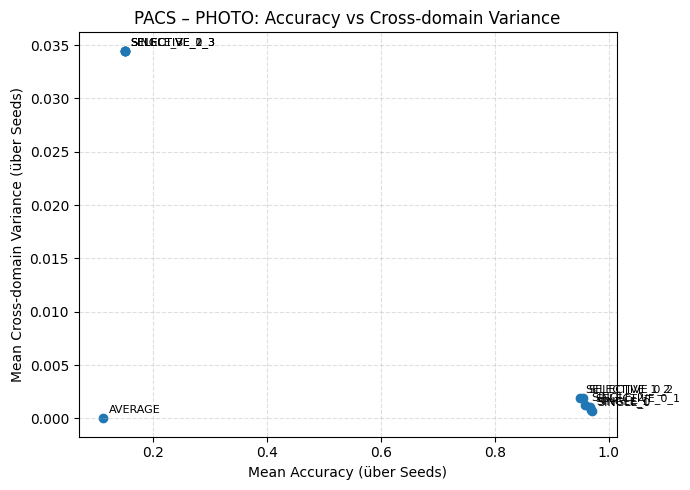

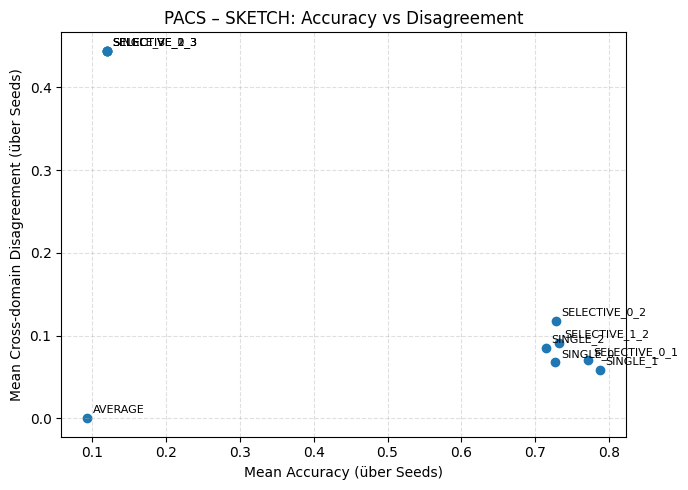

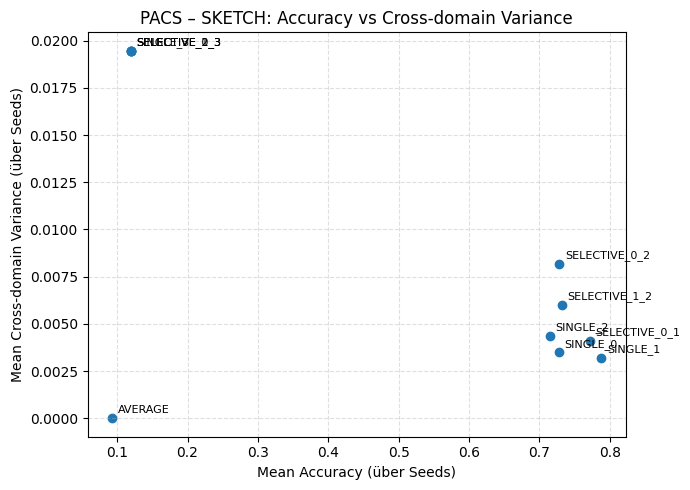

In [7]:
def plot_scatter_by_domain(df_domain, domain_name):
    # Entferne Modi ohne Mean Accuracy
    d = df_domain.dropna(subset=["mean_accuracy"]).copy()
    if d.empty:
        return

    # Sortiere Modi (für konsistente Annotation-Reihenfolge)
    d = d.sort_values(by="mode", key=lambda s: s.map(mode_sort_key))

    # 1) Accuracy vs Disagreement
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(d["mean_accuracy"].values, d["mean_cross_domain_disagreement"].values)
    for _, r in d.iterrows():
        ax.annotate(r["mode"], (r["mean_accuracy"], r["mean_cross_domain_disagreement"]),
                    xytext=(4, 4), textcoords="offset points", fontsize=8)
    ax.set_title(f"PACS – {domain_name}: Accuracy vs Disagreement")
    ax.set_xlabel("Mean Accuracy (über Seeds)")
    ax.set_ylabel("Mean Cross-domain Disagreement (über Seeds)")
    ax.grid(linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    # 2) Accuracy vs Cross-domain Variance
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(d["mean_accuracy"].values, d["mean_cross_domain_variance"].values)
    for _, r in d.iterrows():
        ax.annotate(r["mode"], (r["mean_accuracy"], r["mean_cross_domain_variance"]),
                    xytext=(4, 4), textcoords="offset points", fontsize=8)
    ax.set_title(f"PACS – {domain_name}: Accuracy vs Cross-domain Variance")
    ax.set_xlabel("Mean Accuracy (über Seeds)")
    ax.set_ylabel("Mean Cross-domain Variance (über Seeds)")
    ax.grid(linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# Erzeuge Scatterplots je Domain
for dom in df["test_domain"].cat.categories:
    sub = df[df["test_domain"] == dom]
    if len(sub) > 0:
        plot_scatter_by_domain(sub, dom)

/tmp/ipykernel_3425486/3366763029.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=modes_sorted, showmeans=True)


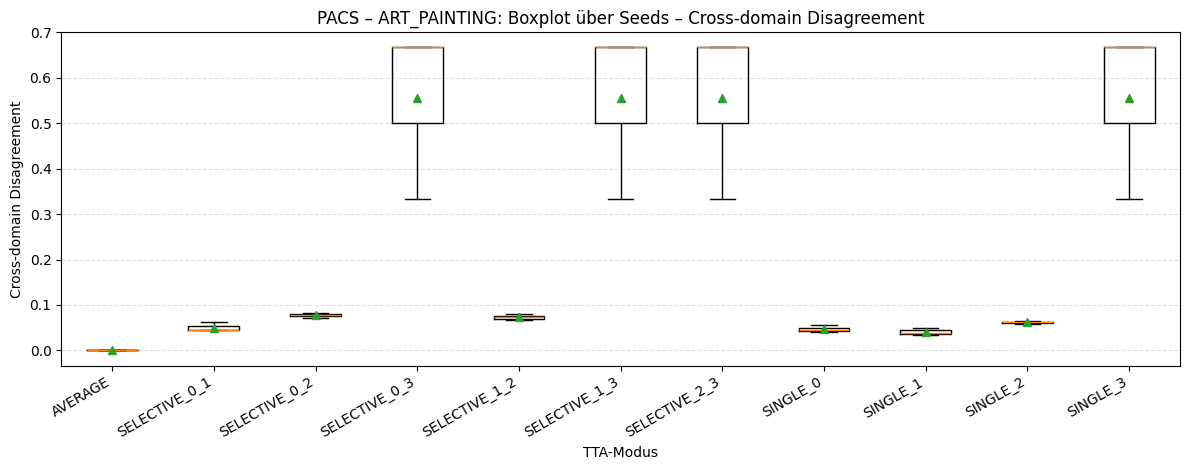

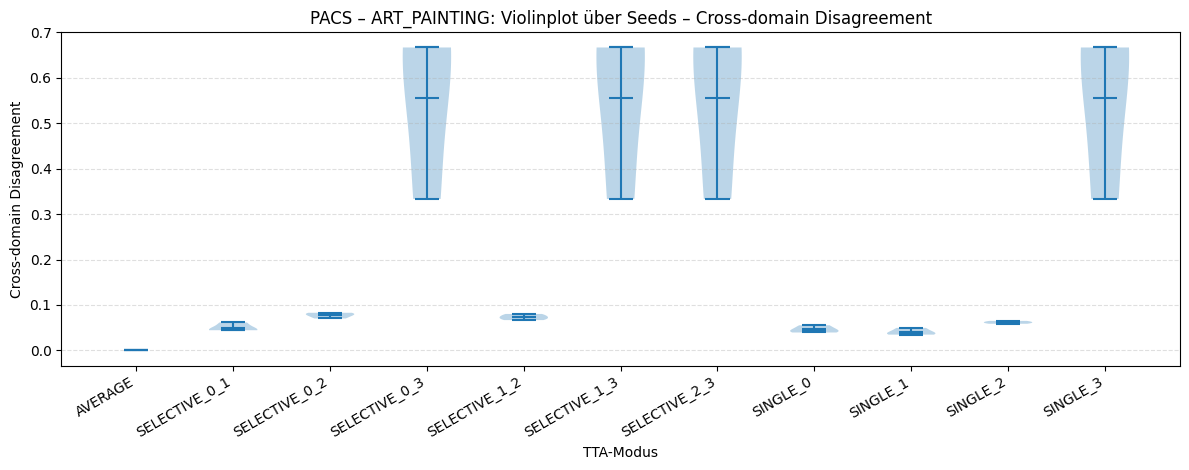

/tmp/ipykernel_3425486/3366763029.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=modes_sorted, showmeans=True)


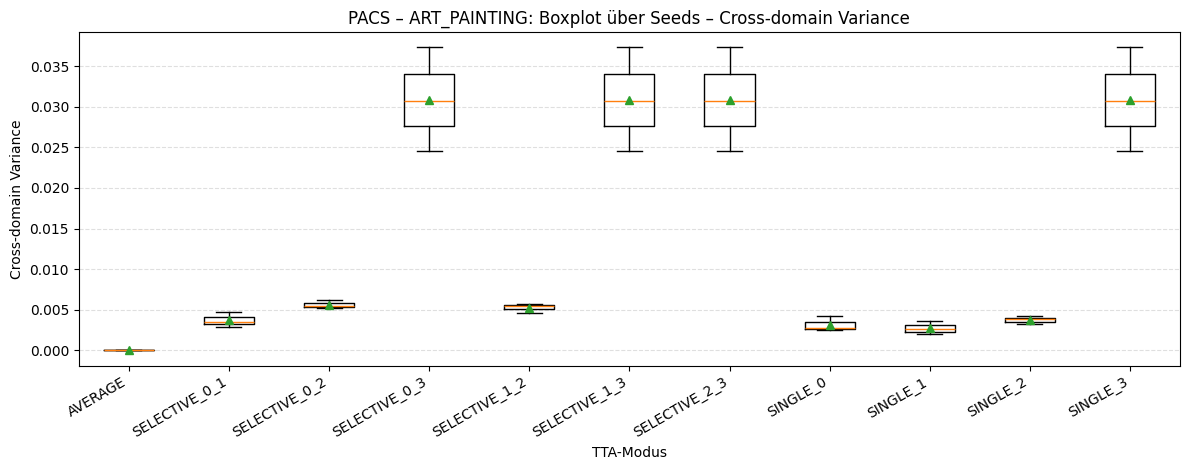

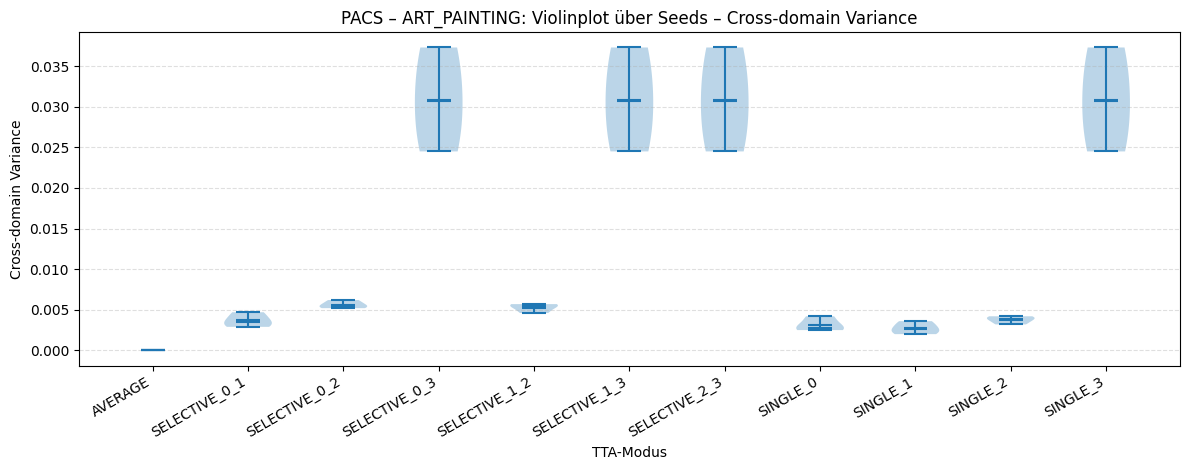

/tmp/ipykernel_3425486/3366763029.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=modes_sorted, showmeans=True)


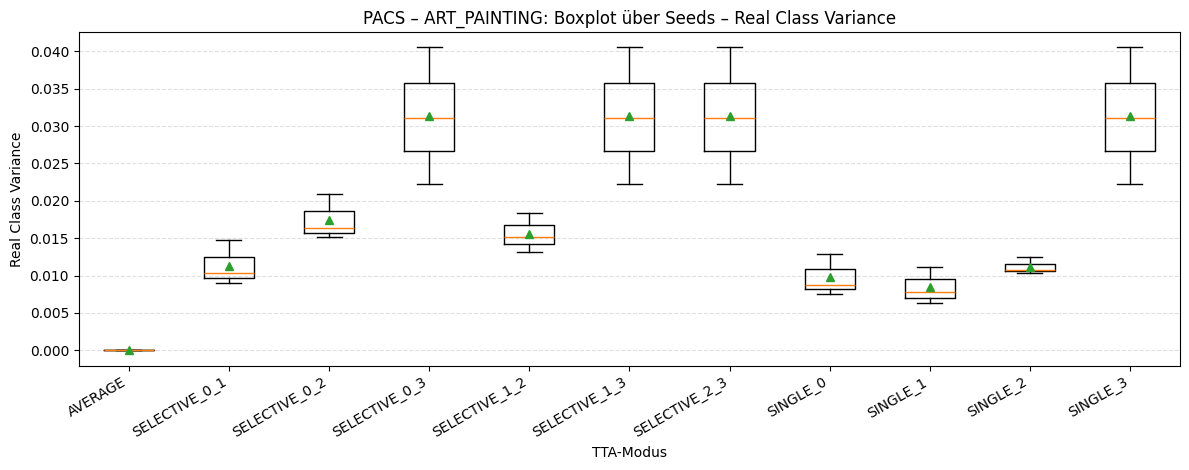

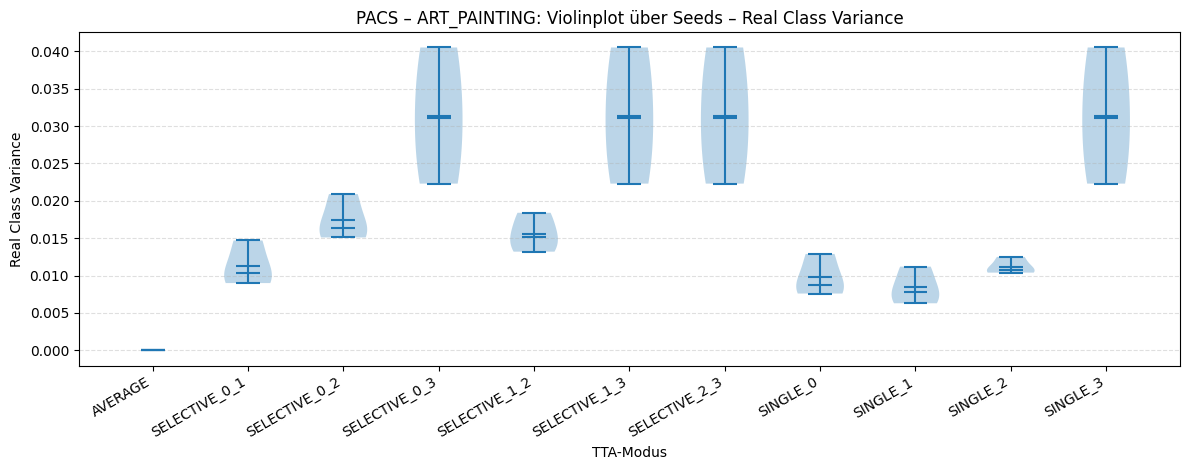

/tmp/ipykernel_3425486/3366763029.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=modes_sorted, showmeans=True)


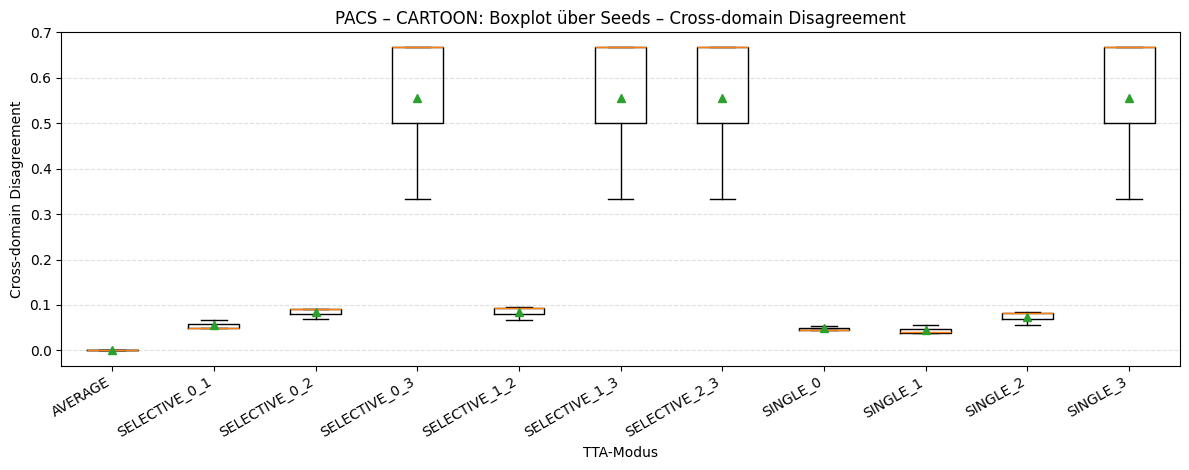

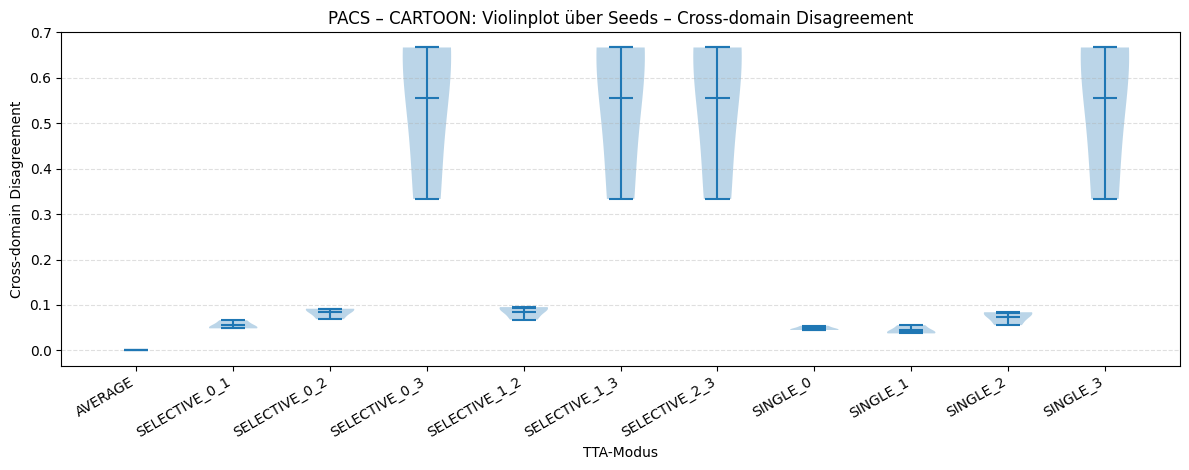

/tmp/ipykernel_3425486/3366763029.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=modes_sorted, showmeans=True)


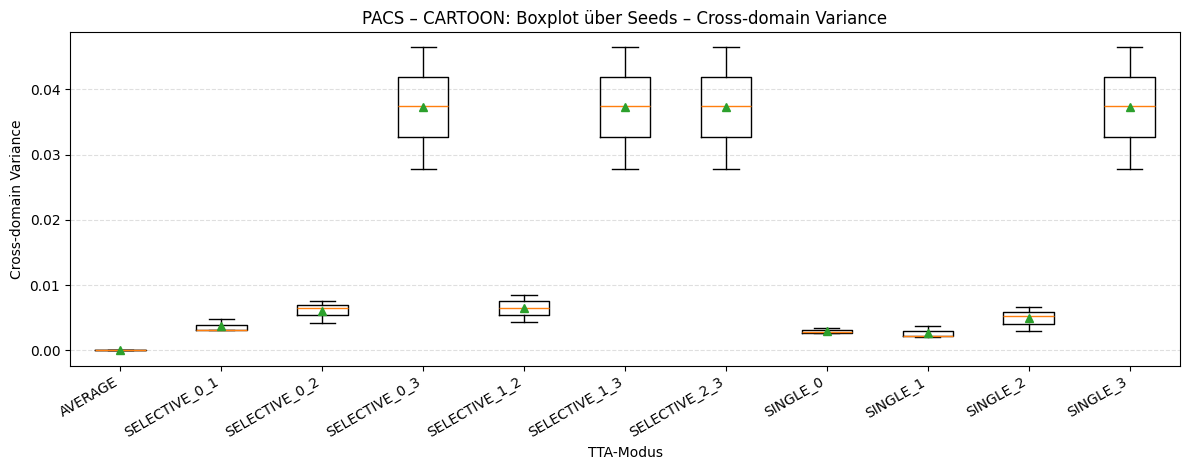

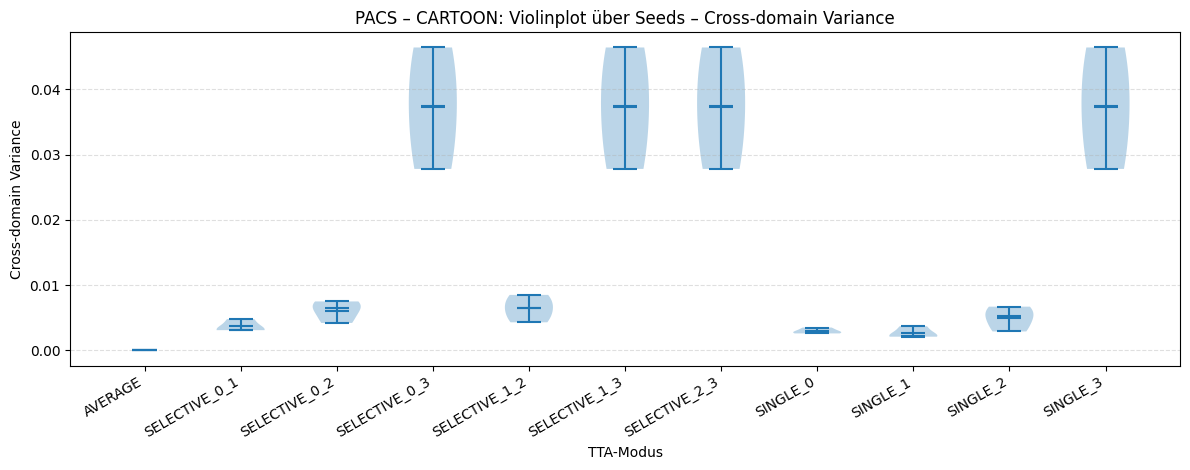

/tmp/ipykernel_3425486/3366763029.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=modes_sorted, showmeans=True)


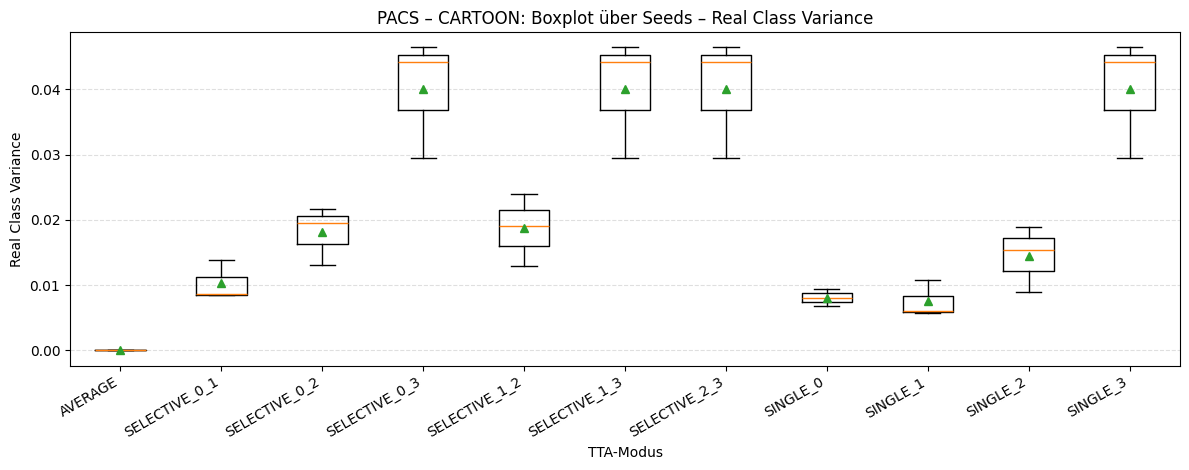

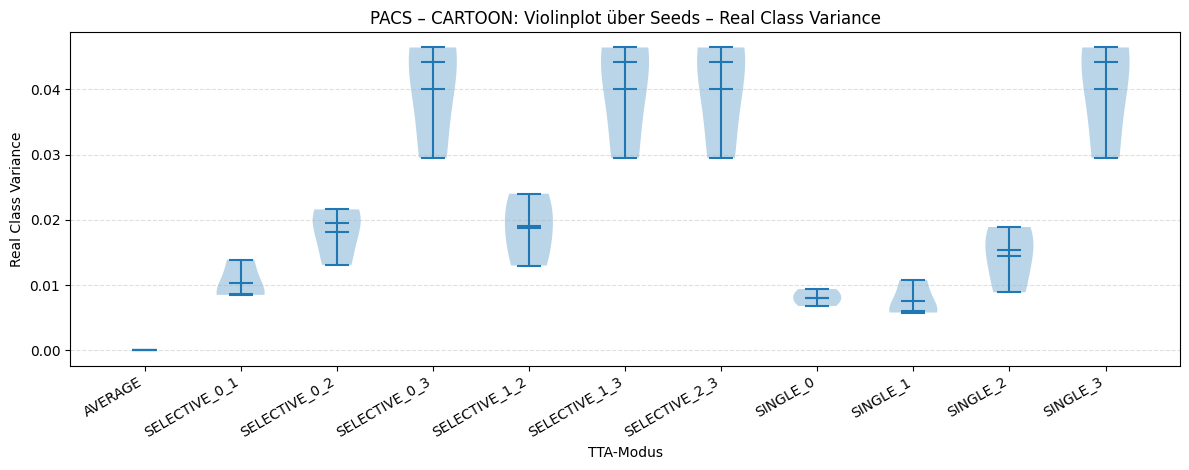

/tmp/ipykernel_3425486/3366763029.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=modes_sorted, showmeans=True)


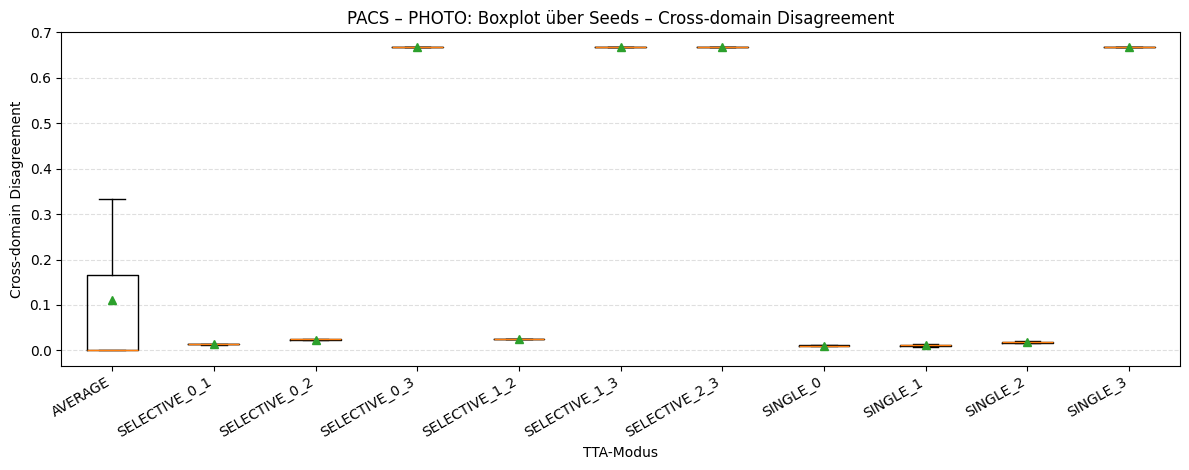

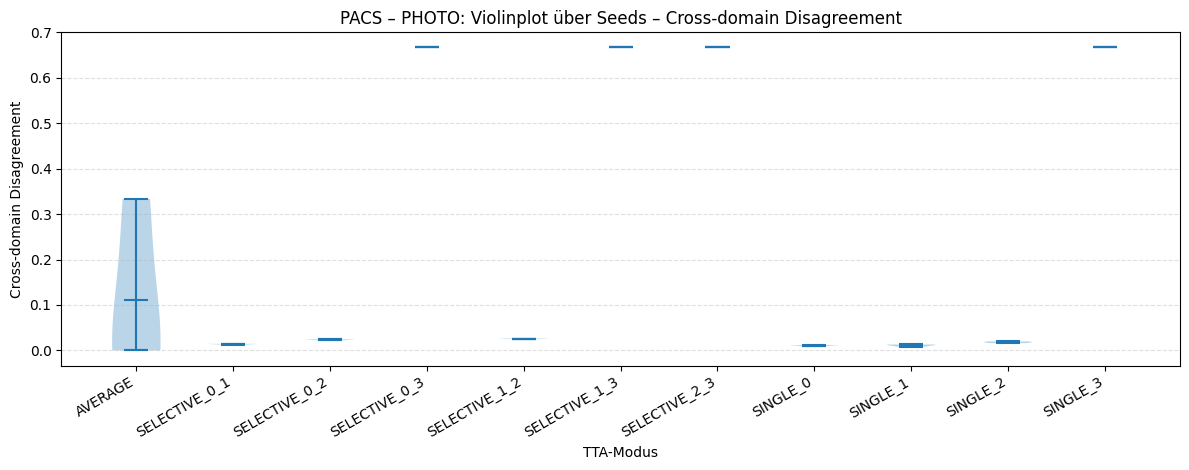

/tmp/ipykernel_3425486/3366763029.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=modes_sorted, showmeans=True)


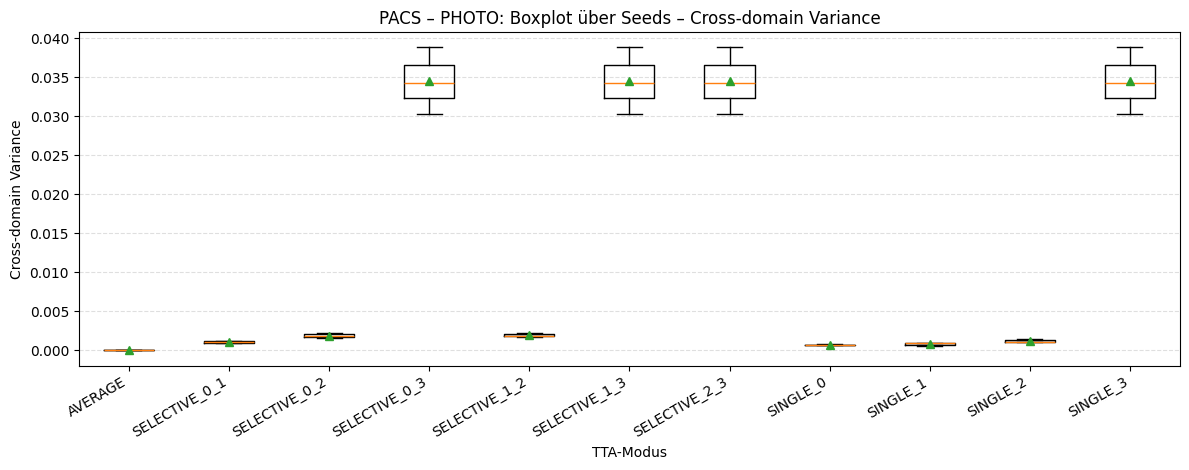

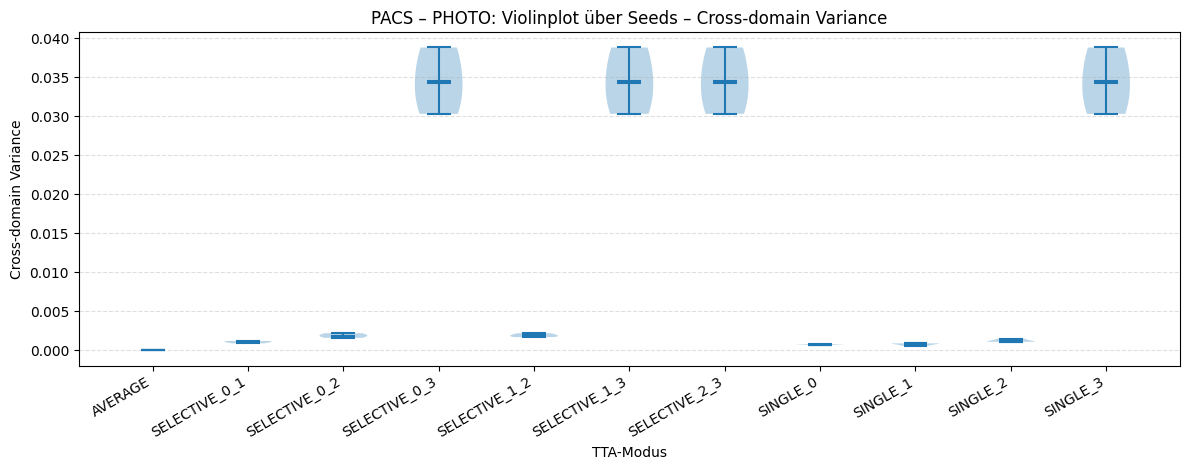

/tmp/ipykernel_3425486/3366763029.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=modes_sorted, showmeans=True)


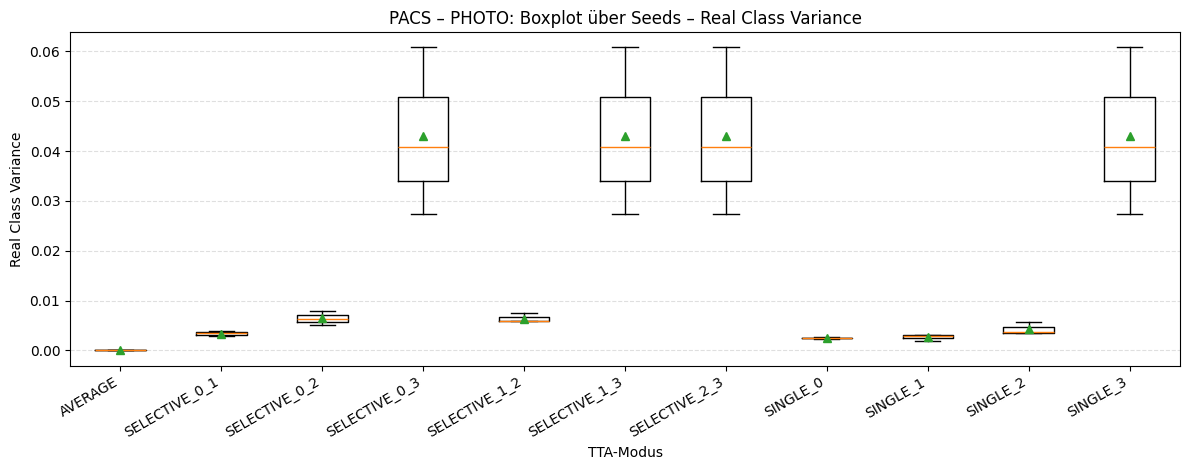

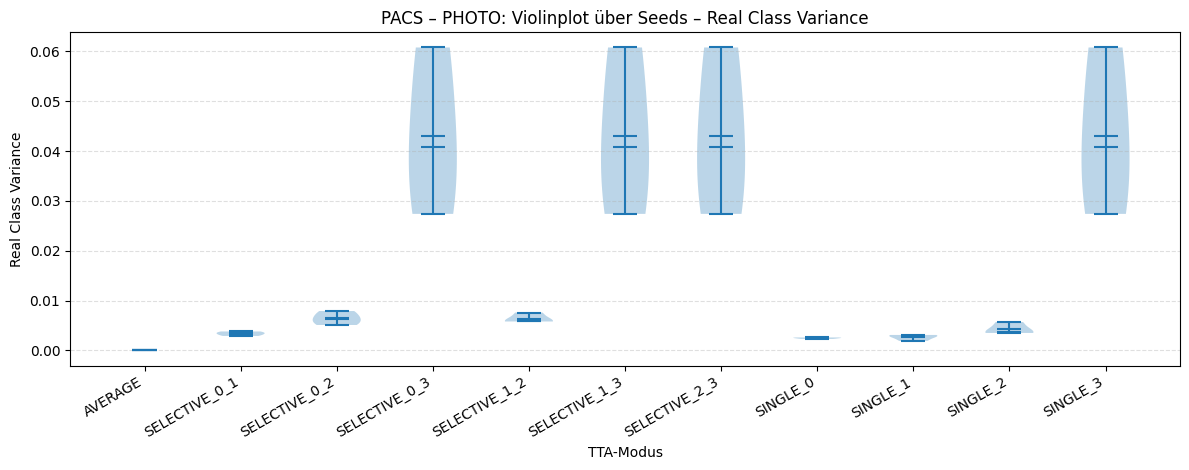

/tmp/ipykernel_3425486/3366763029.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=modes_sorted, showmeans=True)


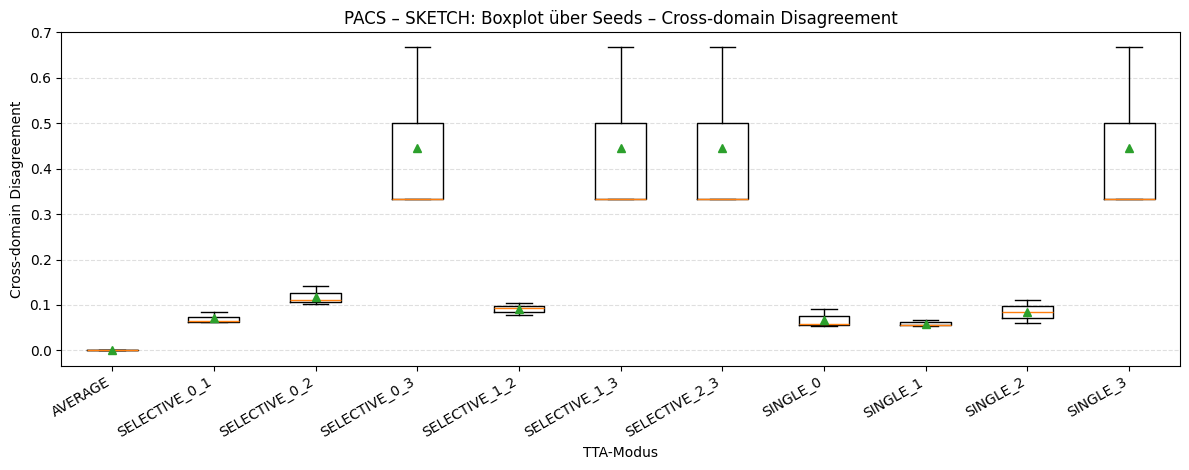

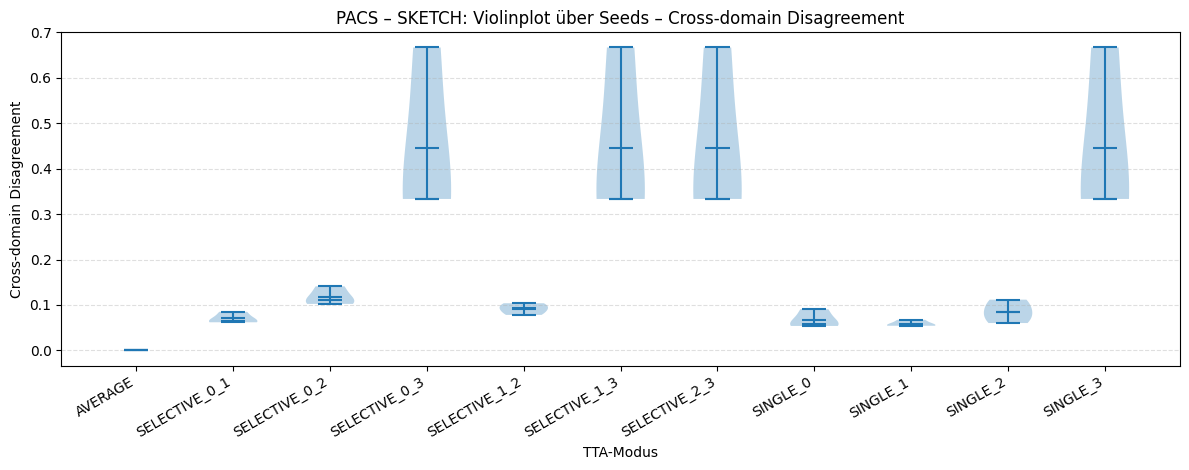

/tmp/ipykernel_3425486/3366763029.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=modes_sorted, showmeans=True)


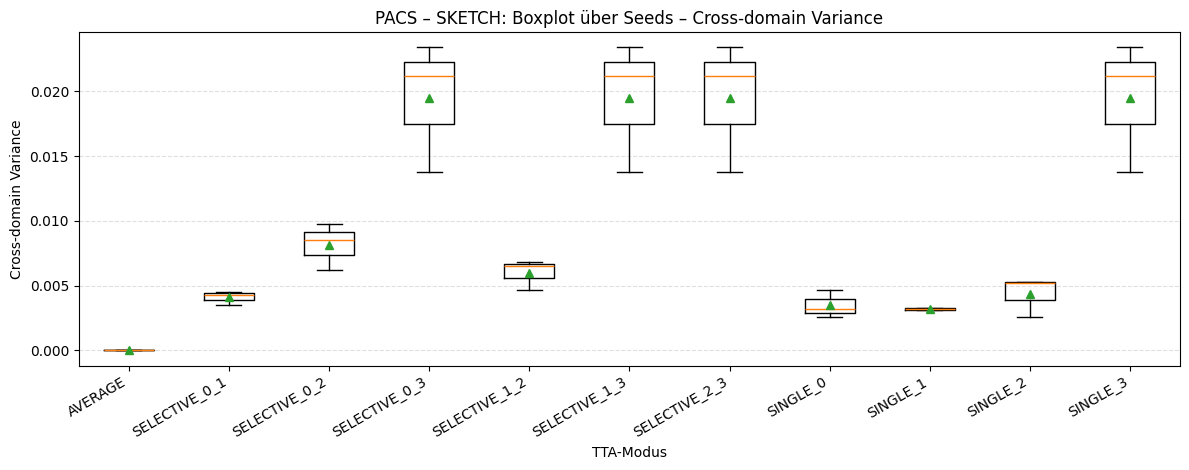

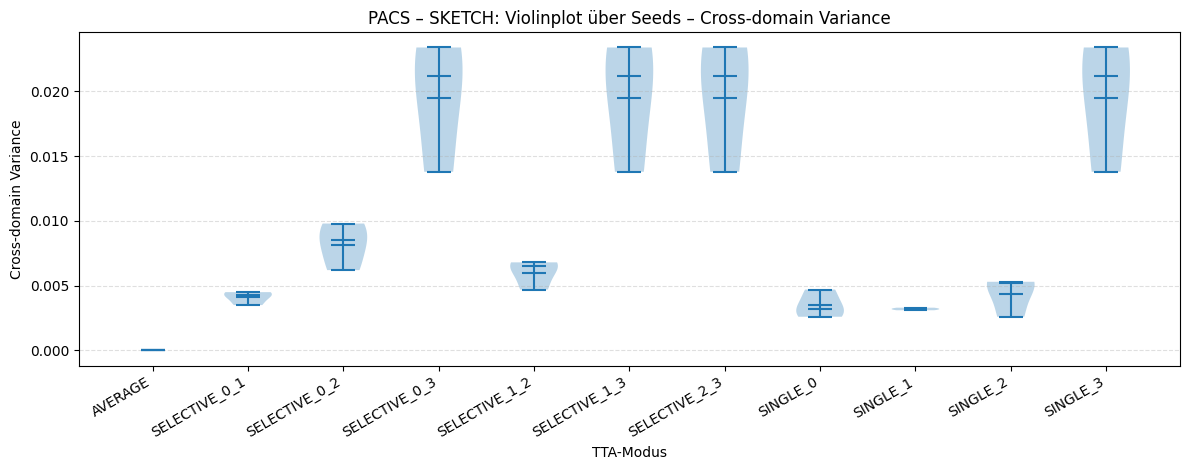

/tmp/ipykernel_3425486/3366763029.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=modes_sorted, showmeans=True)


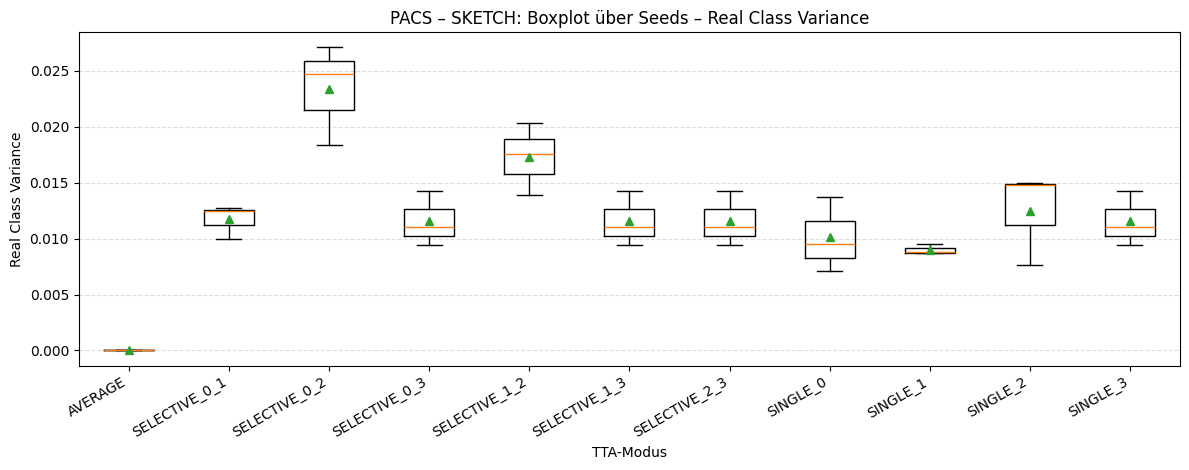

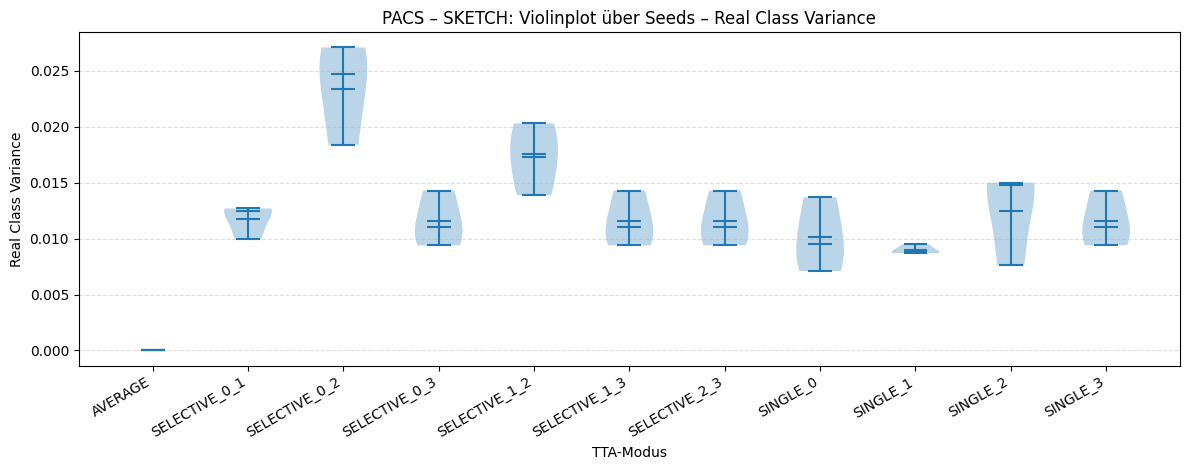

In [11]:
def box_and_violin_by_domain(df_seed: pd.DataFrame, domain_name: str):
    d = df_seed[df_seed["test_domain"] == domain_name].copy()
    if d.empty:
        return

    # Modi sortieren
    modes_sorted = sorted(d["mode"].unique(), key=mode_sort_key)
    d["mode"] = pd.Categorical(d["mode"], modes_sorted, ordered=True)

    metrics = [
        ("cross_domain_disagreement", "Cross-domain Disagreement"),
        ("cross_domain_variance", "Cross-domain Variance"),
        ("real_class_variance", "Real Class Variance"),
    ]

    for metric_col, metric_label in metrics:
        d_sorted = d.sort_values("mode")

        # --- BOX PLOT ---
        fig, ax = plt.subplots(figsize=(12, 4.8))
        data = [d_sorted[d_sorted["mode"] == m][metric_col].values for m in modes_sorted]
        ax.boxplot(data, labels=modes_sorted, showmeans=True)
        ax.set_title(f"PACS – {domain_name}: Boxplot über Seeds – {metric_label}")
        ax.set_ylabel(metric_label)
        ax.set_xlabel("TTA-Modus")
        ax.grid(axis="y", linestyle="--", alpha=0.4)
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        plt.show()

        # --- VIOLIN PLOT ---
        fig, ax = plt.subplots(figsize=(12, 4.8))
        parts = ax.violinplot(data, showmeans=True, showextrema=True, showmedians=True)
        ax.set_title(f"PACS – {domain_name}: Violinplot über Seeds – {metric_label}")
        ax.set_ylabel(metric_label)
        ax.set_xlabel("TTA-Modus")
        ax.grid(axis="y", linestyle="--", alpha=0.4)
        ax.set_xticks(np.arange(1, len(modes_sorted)+1))
        ax.set_xticklabels(modes_sorted, rotation=30, ha="right")
        plt.tight_layout()
        plt.show()

# Ausführen für alle Domains
for dom in domain_order:
    box_and_violin_by_domain(seed_df, dom)

[check] mean_cross_domain_disagreement: 44 Zeilen ohne NaN


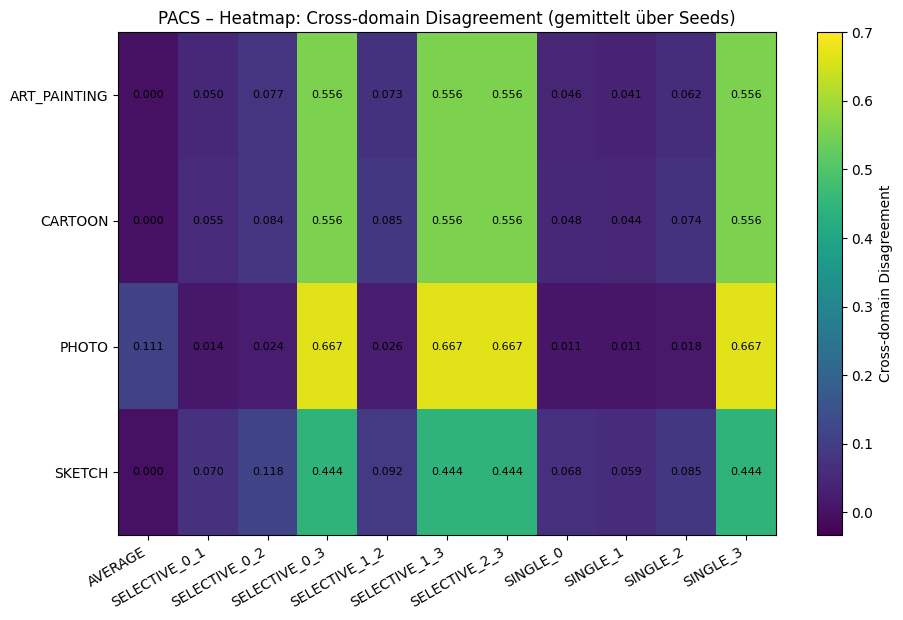

[check] mean_cross_domain_variance: 44 Zeilen ohne NaN


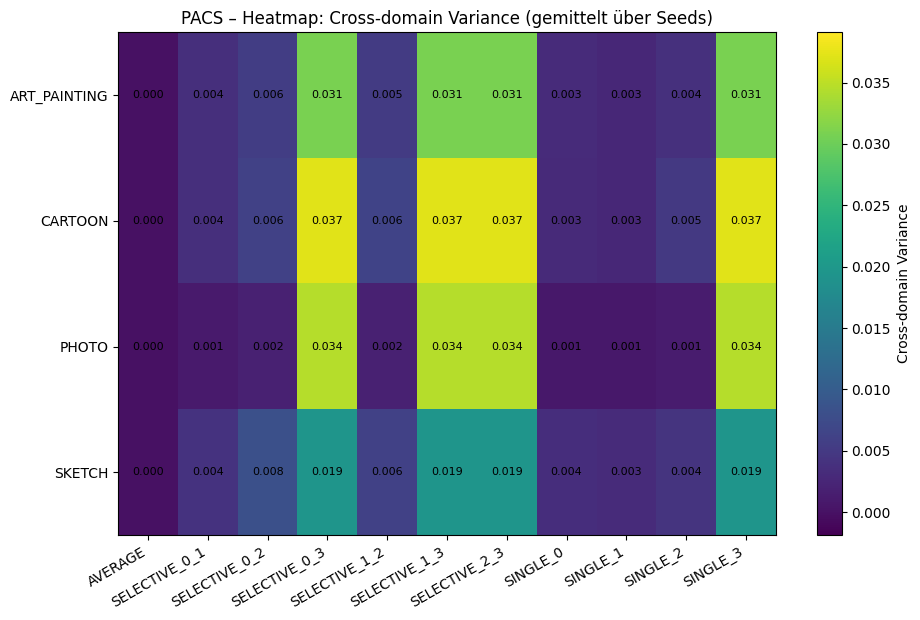

[check] mean_real_class_variance: 44 Zeilen ohne NaN


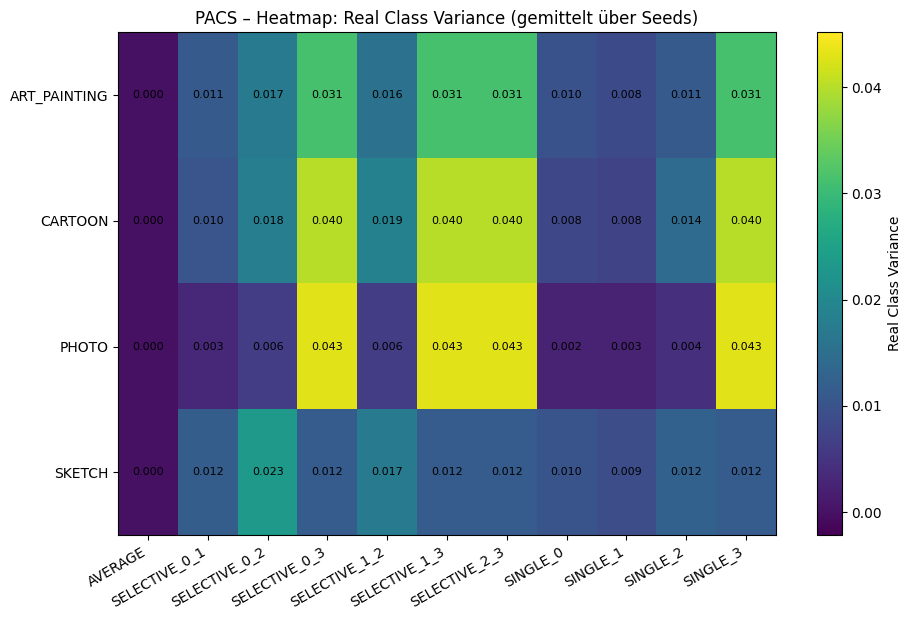

[check] mean_accuracy: 44 Zeilen ohne NaN


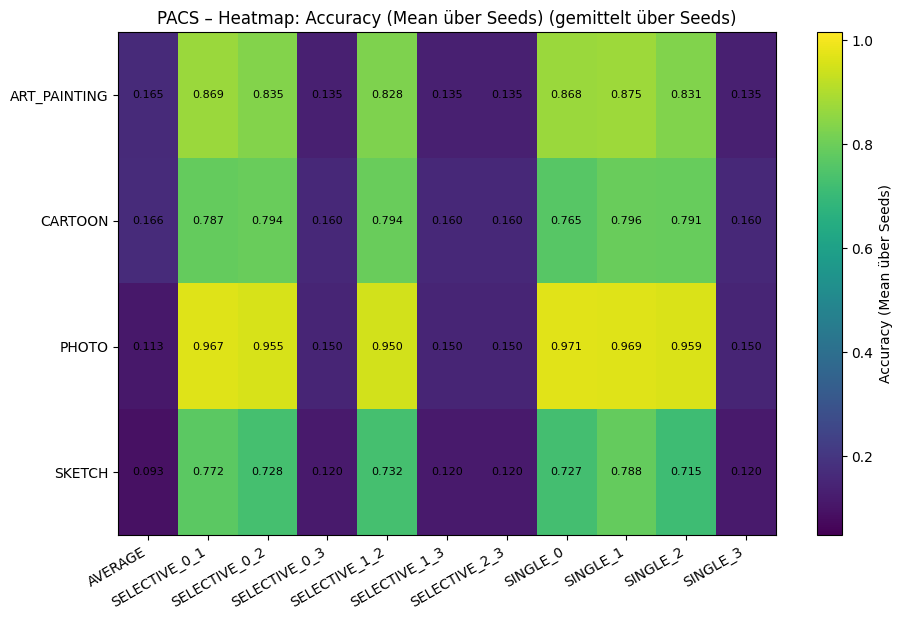

In [15]:
def heatmap(metric_col: str, metric_label: str, df_agg: pd.DataFrame, cmap="viridis"):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # 1) Kopie + nur Zeilen mit Metrik
    d = df_agg.dropna(subset=[metric_col]).copy()
    if d.empty:
        print(f"[heatmap] Keine Daten für {metric_col}.")
        return

    # 2) Strings erzwingen (falls irgendwo Listen/Objekte eingeschlichen sind)
    d["test_domain"] = d["test_domain"].astype(str)
    d["mode"] = d["mode"].astype(str)

    # 3) Feste Reihenfolgen herstellen (ohne key=... in sort_values)
    #    a) Testdomains (deine feste Reihenfolge)
    domain_order = ["ART_PAINTING", "CARTOON", "PHOTO", "SKETCH"]
    # Fallback: falls df andere Domains enthält, hänge sie hinten dran
    rest_domains = [x for x in d["test_domain"].unique() if x not in domain_order]
    domain_cats = domain_order + sorted(rest_domains)

    d["test_domain"] = pd.Categorical(d["test_domain"], categories=domain_cats, ordered=True)

    #    b) Modi – mit deinem mode_sort_key eine *KATEGORIE* bauen
    mode_order = sorted(d["mode"].unique(), key=mode_sort_key)
    d["mode"] = pd.Categorical(d["mode"], categories=mode_order, ordered=True)

    # 4) Sortieren OHNE key-Funktion
    d = d.sort_values(["test_domain", "mode"])

    # 5) Pivot (Domain × Modus)
    pivot = d.pivot(index="test_domain", columns="mode", values=metric_col)

    # 6) Farbbereich
    v = d[metric_col].astype(float)
    vmin, vmax = get_vmin_vmax(v, pad=0.05)

    # 7) Zeichnen
    fig_w = max(8, 0.6 * len(pivot.columns) + 3)
    fig_h = 1.2 * len(pivot.index) + 1.5
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    im = ax.imshow(pivot.values.astype(float), aspect="auto", vmin=vmin, vmax=vmax, cmap=cmap)

    ax.set_title(f"PACS – Heatmap: {metric_label} (gemittelt über Seeds)")
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns, rotation=30, ha="right")

    # Werte einblenden
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            if pd.notna(val):
                ax.text(j, i, f"{float(val):.3f}", ha="center", va="center", fontsize=8)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(metric_label)

    ax.grid(False)
    plt.tight_layout()
    plt.show()


# (1) In Jupyter einmalig aktivieren:
%matplotlib inline

# (2) Mini-Debug-Helfer: zeigt, ob in df Daten für die gewünschte Metrik liegen
def _check_metric(df_agg, metric_col):
    if metric_col not in df_agg.columns:
        print(f"[check] Spalte '{metric_col}' nicht in df_agg.columns.")
        print("Vorhandene Spalten:", list(df_agg.columns))
        return False
    d = df_agg.dropna(subset=[metric_col])
    print(f"[check] {metric_col}: {len(d)} Zeilen ohne NaN")
    if d.empty:
        print(f"[check] Keine Daten für {metric_col} -> keine Heatmap.")
        return False
    return True

# (3) Aufrufe – ersetze df ggf. durch deinen Aggregat-DataFrame-Namen
if _check_metric(df, "mean_cross_domain_disagreement"):
    heatmap("mean_cross_domain_disagreement", "Cross-domain Disagreement", df)

if _check_metric(df, "mean_cross_domain_variance"):
    heatmap("mean_cross_domain_variance", "Cross-domain Variance", df)

if _check_metric(df, "mean_real_class_variance"):
    heatmap("mean_real_class_variance", "Real Class Variance", df)

if _check_metric(df, "mean_accuracy"):
    heatmap("mean_accuracy", "Accuracy (Mean über Seeds)", df)



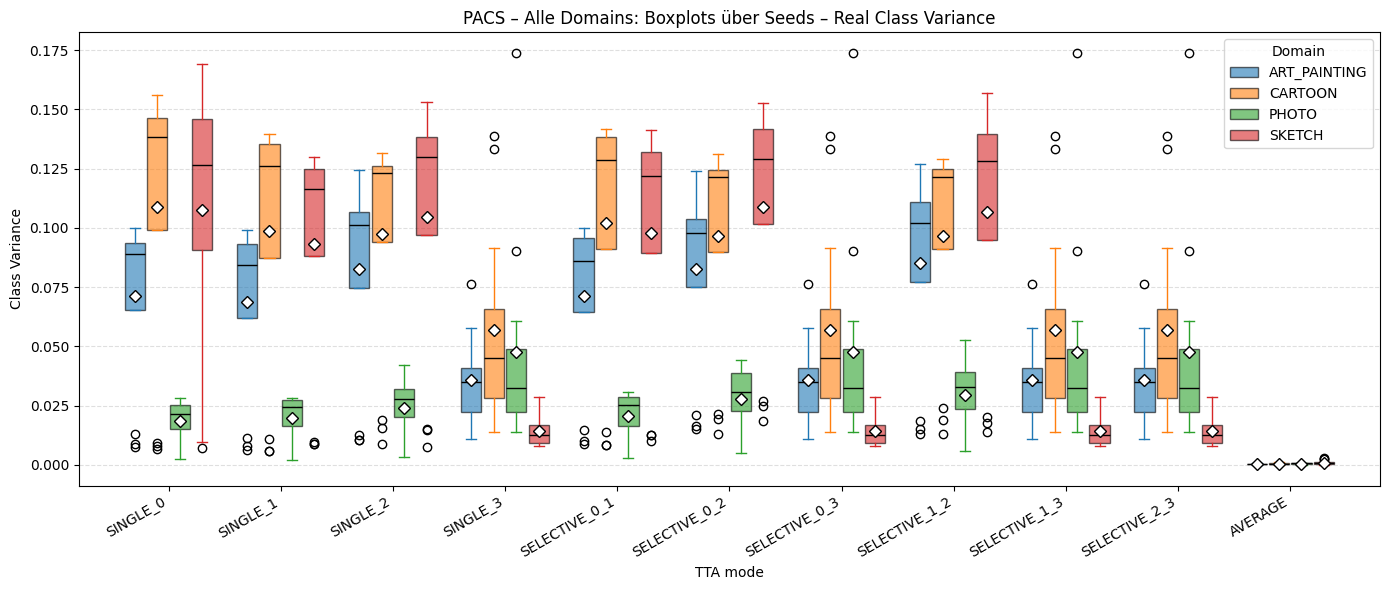

In [ ]:
FILE_PATH = "pacs_tta_results_all_domains_20250820_115822.txt"

def parse_real_class_variance(file_path: str) -> pd.DataFrame:
    """
    Parst die Experiment-Textdatei und extrahiert:
    - test_domain
    - mode
    - seed
    - real_class_variance
    """
    domains, modes, seeds, variances = [], [], [], []
    current_domain, current_mode, current_seed = None, None, None

    with open(file_path, "r", encoding="utf-8") as f:
        for raw in f:
            line = raw.strip()

            m = re.match(r"=== TEST DOMAIN: (.+) ===", line)
            if m:
                current_domain = m.group(1)
                continue

            m = re.match(r"Mode:\s*(.+)", line)
            if m:
                current_mode = m.group(1).strip()
                continue

            m = re.match(r"Seed:\s*(\d+)", line)
            if m:
                current_seed = int(m.group(1))
                continue

            # Zeilen mit "Real class variance: <wert>"
            m = re.match(r".*Real class variance:\s*([0-9.]+)", line, flags=re.IGNORECASE)
            if m and current_domain and current_mode and current_seed is not None:
                val = float(m.group(1))
                domains.append(current_domain)
                modes.append(current_mode)
                seeds.append(current_seed)
                variances.append(val)

    df = pd.DataFrame({
        "test_domain": domains,
        "mode": modes,
        "seed": seeds,
        "real_class_variance": variances
    })
    return df


def mode_sort_key(mode: str):
    """
    Sorgt für eine sinnvolle Reihenfolge:
    SINGLE_0..3, dann SELECTIVE_* (lexi nach Indizes), dann AVERAGE.
    """
    mode = mode.upper()
    if mode.startswith("SINGLE"):
        cat = 0
        # Zahl extrahieren (z.B. 'SINGLE_2' -> 2); fallback 999
        m = re.search(r"SINGLE_(\d+)", mode)
        idx = int(m.group(1)) if m else 999
        subkey = (idx,)
    elif mode.startswith("SELECTIVE"):
        cat = 1
        # Zahlenfolge extrahieren (z.B. 'SELECTIVE_0_2' -> (0,2))
        nums = tuple(int(x) for x in re.findall(r"(\d+)", mode))
        subkey = nums if nums else (999,)
    elif mode.startswith("AVERAGE"):
        cat = 2
        subkey = (0,)
    else:
        cat = 9
        subkey = (mode,)
    return (cat, *subkey)


def plot_real_class_variance_all_domains(file_path: str,
                                         domain_order=("ART_PAINTING","CARTOON","PHOTO","SKETCH"),
                                         title="PACS – Alle Domains: Boxplots über Seeds – Real Class Variance"):
    # Datei parsen
    df = parse_real_class_variance(file_path)

    if df.empty:
        raise ValueError("Keine Daten gefunden (Real Class Variance). Prüfe den Dateiinhalt/Dateipfad.")

    # Modi sortieren
    modes_sorted = sorted(df["mode"].unique(), key=mode_sort_key)
    df["mode"] = pd.Categorical(df["mode"], modes_sorted, ordered=True)

    # Domain-Reihenfolge (fallback: so wie im DataFrame vorhanden)
    if domain_order is None:
        domain_order = list(df["test_domain"].unique())
    else:
        # nur Domains verwenden, die auch tatsächlich vorhanden sind
        domain_order = [d for d in domain_order if d in set(df["test_domain"])]

    # Daten pro Domain und Modus: Liste von Arrays (Seeds) für jede Kombination
    grouped = {
        dom: [df[(df["test_domain"] == dom) & (df["mode"] == m)]["real_class_variance"].values
              for m in modes_sorted]
        for dom in domain_order
    }

    # Gruppierte Boxplots vorbereiten
    n_modes = len(modes_sorted)
    n_domains = len(domain_order)
    if n_modes == 0 or n_domains == 0:
        raise ValueError("Nicht genügend Daten zum Plotten.")

    group_width = 0.8                  # Gesamtbreite einer Modus-Gruppe
    box_width = group_width / n_domains
    offsets = np.linspace(-group_width/2 + box_width/2,
                          group_width/2 - box_width/2,
                          n_domains)

    fig, ax = plt.subplots(figsize=(14, 6))
    handles = []

    # Farbzyklus von Matplotlib
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for j, dom in enumerate(domain_order):
        positions = np.arange(1, n_modes + 1) + offsets[j]
        bp = ax.boxplot(
            grouped[dom],
            positions=positions,
            widths=box_width * 0.9,
            showmeans=True,
            patch_artist=True
        )

        color = colors[j % len(colors)]
        for patch in bp['boxes']:
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        for element in ('whiskers','caps'):
            for artist in bp[element]:
                artist.set_color(color)
        for median in bp['medians']:
            median.set_color('black')
        for mean in bp['means']:
            mean.set_marker('D')
            mean.set_markerfacecolor('white')
            mean.set_markeredgecolor('black')

        handles.append(bp['boxes'][0])

    # Achsen & Beschriftungen
    ax.set_xticks(np.arange(1, n_modes + 1))
    ax.set_xticklabels(modes_sorted, rotation=30, ha="right")
    ax.set_xlabel("TTA mode")
    ax.set_ylabel("Class Variance")
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    # Legende
    ax.legend(handles, domain_order, title="Domain", loc="best")

    plt.tight_layout()
    plt.show()

plot_real_class_variance_all_domains(FILE_PATH)

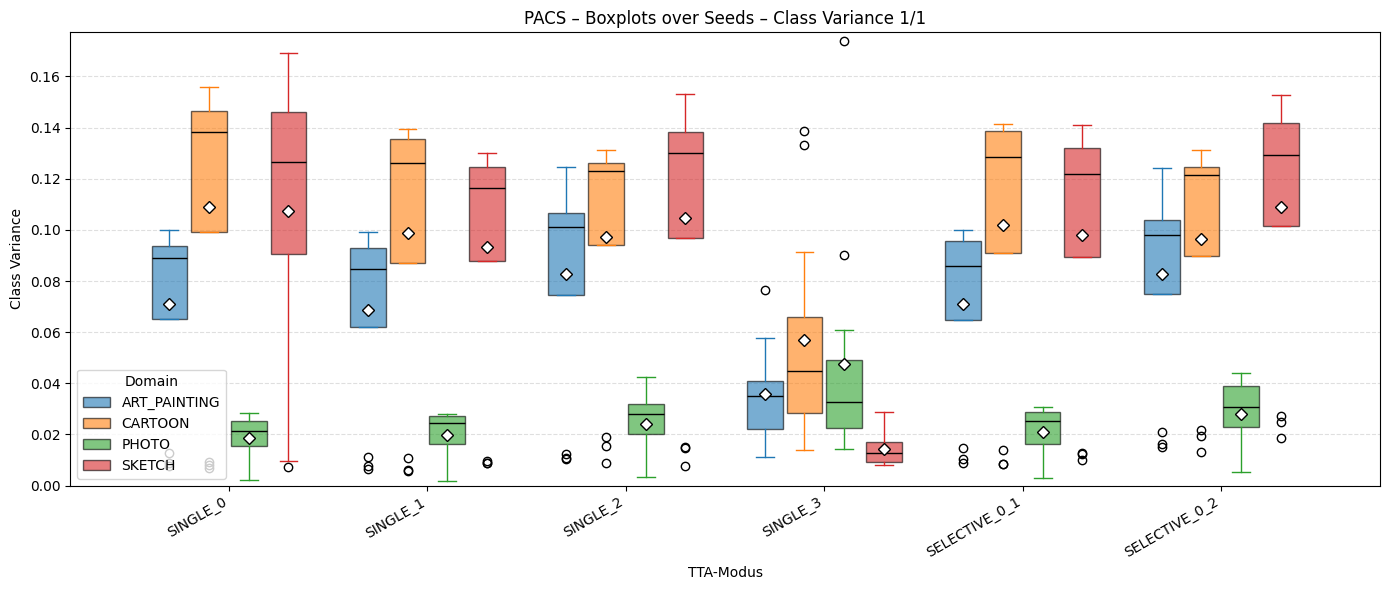

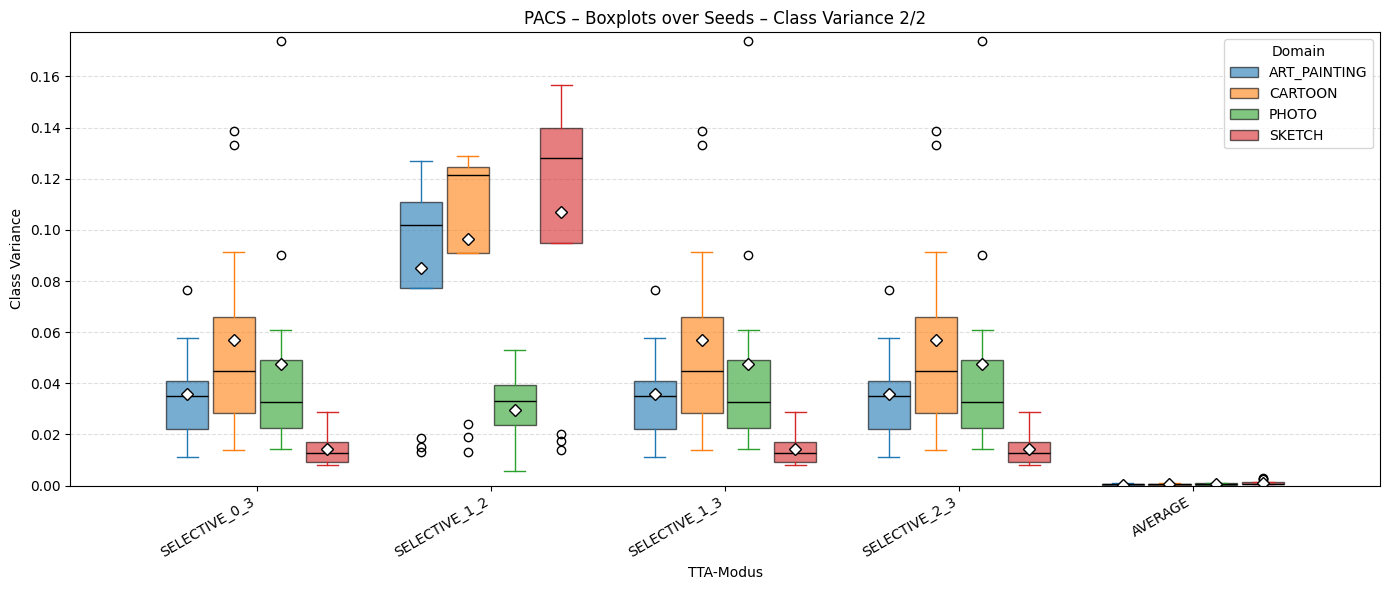

In [9]:
FILE_PATH = "pacs_tta_results_all_domains_20250820_115822.txt"

def parse_real_class_variance(file_path: str) -> pd.DataFrame:
    """
    Parst die Experiment-Textdatei und extrahiert:
    - test_domain
    - mode
    - seed
    - real_class_variance
    """
    domains, modes, seeds, variances = [], [], [], []
    current_domain, current_mode, current_seed = None, None, None

    with open(file_path, "r", encoding="utf-8") as f:
        for raw in f:
            line = raw.strip()

            m = re.match(r"=== TEST DOMAIN: (.+) ===", line)
            if m:
                current_domain = m.group(1)
                continue

            m = re.match(r"Mode:\s*(.+)", line)
            if m:
                current_mode = m.group(1).strip()
                continue

            m = re.match(r"Seed:\s*(\d+)", line)
            if m:
                current_seed = int(m.group(1))
                continue

            # "Real class variance: <wert>"
            m = re.match(r".*Real class variance:\s*([0-9.]+)", line, flags=re.IGNORECASE)
            if m and current_domain and current_mode and current_seed is not None:
                val = float(m.group(1))
                domains.append(current_domain)
                modes.append(current_mode)
                seeds.append(current_seed)
                variances.append(val)

    return pd.DataFrame({
        "test_domain": domains,
        "mode": modes,
        "seed": seeds,
        "real_class_variance": variances
    })


def mode_sort_key(mode: str):
    """
    Reihenfolge:
    SINGLE_0..3, dann SELECTIVE_* (lexi nach Zahlen), dann AVERAGE, sonst hinten.
    """
    mode = mode.upper()
    if mode.startswith("SINGLE"):
        cat = 0
        m = re.search(r"SINGLE_(\d+)", mode)
        idx = int(m.group(1)) if m else 999
        subkey = (idx,)
    elif mode.startswith("SELECTIVE"):
        cat = 1
        nums = tuple(int(x) for x in re.findall(r"(\d+)", mode))
        subkey = nums if nums else (999,)
    elif mode.startswith("AVERAGE"):
        cat = 2
        subkey = (0,)
    else:
        cat = 9
        subkey = (mode,)
    return (cat, *subkey)


def _plot_subset(ax, df, modes_subset, domain_order):
    """
    Hilfsfunktion: zeichnet gruppierte Boxplots für einen Modus-Teilbereich in die Achse ax.
    """
    # Sicherstellen, dass Modus als Kategorie in der gewünschten Reihenfolge vorliegt
    df_local = df.copy()
    df_local["mode"] = pd.Categorical(df_local["mode"], modes_subset, ordered=True)

    # Daten pro Domain und Modus
    grouped = {
        dom: [df_local[(df_local["test_domain"] == dom) & (df_local["mode"] == m)]["real_class_variance"].values
              for m in modes_subset]
        for dom in domain_order
    }

    n_modes = len(modes_subset)
    n_domains = len(domain_order)

    group_width = 0.8
    box_width = group_width / n_domains
    offsets = np.linspace(-group_width/2 + box_width/2,
                          group_width/2 - box_width/2,
                          n_domains)

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    handles = []
    for j, dom in enumerate(domain_order):
        positions = np.arange(1, n_modes + 1) + offsets[j]
        bp = ax.boxplot(
            grouped[dom],
            positions=positions,
            widths=box_width * 0.9,
            showmeans=True,
            patch_artist=True
        )

        color = colors[j % len(colors)]
        for patch in bp['boxes']:
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        for element in ('whiskers','caps'):
            for artist in bp[element]:
                artist.set_color(color)
        for median in bp['medians']:
            median.set_color('black')
        for mean in bp['means']:
            mean.set_marker('D')
            mean.set_markerfacecolor('white')
            mean.set_markeredgecolor('black')

        handles.append(bp['boxes'][0])

    ax.set_xticks(np.arange(1, len(modes_subset) + 1))
    ax.set_xticklabels(modes_subset, rotation=30, ha="right")
    ax.set_xlabel("TTA-Modus")
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    return handles  # für Legende


def plot_real_class_variance_two_figs(
    file_path: str,
    domain_order=("ART_PAINTING","CARTOON","PHOTO","SKETCH"),
    split_first_count: int = 6,
    title_prefix: str = "PACS – Boxplots over Seeds – Class Variance"
):
    """
    Erzeugt zwei Abbildungen:
      - Abbildung 1: die ersten `split_first_count` Modi
      - Abbildung 2: die restlichen Modi
    """
    df = parse_real_class_variance(file_path)
    if df.empty:
        raise ValueError("Keine Daten gefunden (Real Class Variance). Prüfe Datei/Pfad.")

    # Modi sortieren
    modes_sorted = sorted(df["mode"].unique(), key=mode_sort_key)
    df["mode"] = pd.Categorical(df["mode"], modes_sorted, ordered=True)

    # Domain-Reihenfolge validieren
    if domain_order is None:
        domain_order = list(df["test_domain"].unique())
    else:
        domain_order = [d for d in domain_order if d in set(df["test_domain"])]

    # Modus-Teilungen
    modes_first = modes_sorted[:split_first_count]
    modes_second = modes_sorted[split_first_count:]

    if len(modes_first) == 0 or len(modes_second) == 0:
        raise ValueError("Split führt zu leerem Plot. Passe `split_first_count` an.")

    # Einheitliche y-Achse (Min/Max aus allen Daten)
    y_min = df["real_class_variance"].min()
    y_max = df["real_class_variance"].max()
    # kleiner Rand
    pad = 0.02 * (y_max - y_min if y_max > y_min else 1.0)
    y_limits = (max(0, y_min - pad), y_max + pad)

    # --- Abbildung 1 ---
    fig1, ax1 = plt.subplots(figsize=(14, 6))
    handles = _plot_subset(ax1, df, modes_first, domain_order)
    ax1.set_ylabel("Class Variance")
    ax1.set_title(f"{title_prefix} 1/1")
    ax1.set_ylim(*y_limits)
    ax1.legend(handles, domain_order, title="Domain", loc="best")
    plt.tight_layout()
    plt.show()

    # --- Abbildung 2 ---
    fig2, ax2 = plt.subplots(figsize=(14, 6))
    handles2 = _plot_subset(ax2, df, modes_second, domain_order)
    ax2.set_ylabel("Class Variance")
    ax2.set_title(f"{title_prefix} 2/2")
    ax2.set_ylim(*y_limits)
    ax2.legend(handles2, domain_order, title="Domain", loc="best")
    plt.tight_layout()
    plt.show()


# %% Ausführen
assert Path(FILE_PATH).exists(), f"Datei nicht gefunden: {FILE_PATH}"
plot_real_class_variance_two_figs(FILE_PATH, split_first_count=6)

Durchschnittliche (real) Klassenvarianz pro Mode und Domain:


domain_label,Caltech101,LabelMe,SUN09,VOC2007
mode_label,,,,
selective_0_1,0.0011,0.0060,0.0100,0.0080
selective_0_2,0.0054,0.0090,0.0298,0.0192
selective_0_3,0.0110,0.0098,0.0473,0.0346
selective_1_2,0.0061,0.0116,0.0311,0.0217
selective_1_3,0.0110,0.0098,0.0473,0.0346
selective_2_3,0.0055,0.0050,0.0237,0.0173
AVERAGE,NaN,NaN,NaN,NaN



Durchschnittliches (cross-domain) Disagreement pro Mode und Domain:


domain_label,Caltech101,LabelMe,SUN09,VOC2007
mode_label,,,,
selective_0_1,0.0103,0.0263,0.0543,0.0485
selective_0_2,0.0429,0.0456,0.1614,0.0972
selective_0_3,0.1111,0.0000,0.3333,0.2222
selective_1_2,0.0496,0.0531,0.1687,0.1051
selective_1_3,0.1111,0.0000,0.3333,0.2222
selective_2_3,0.0556,0.0000,0.1666,0.1111
AVERAGE,NaN,NaN,NaN,NaN


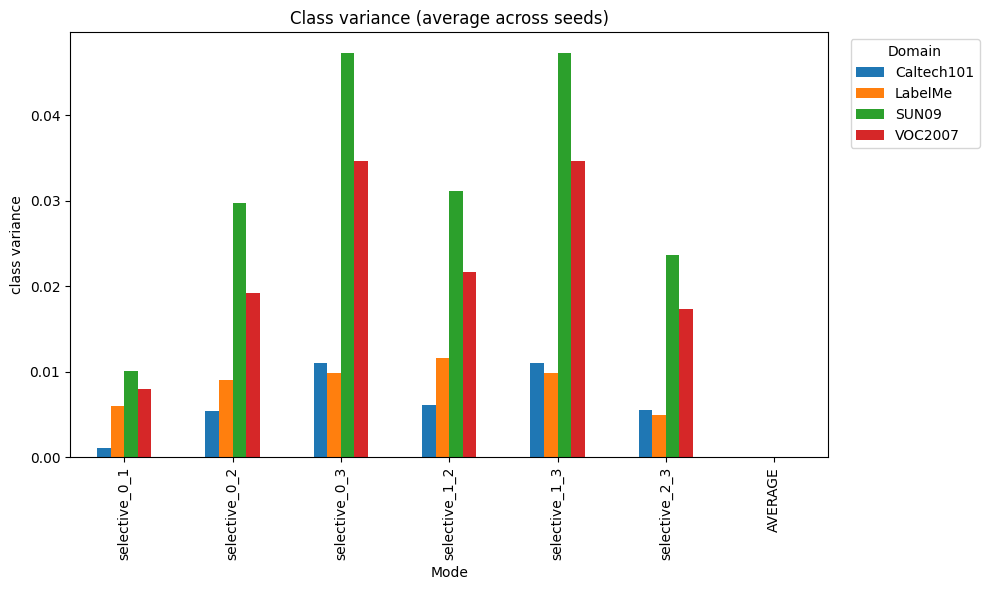

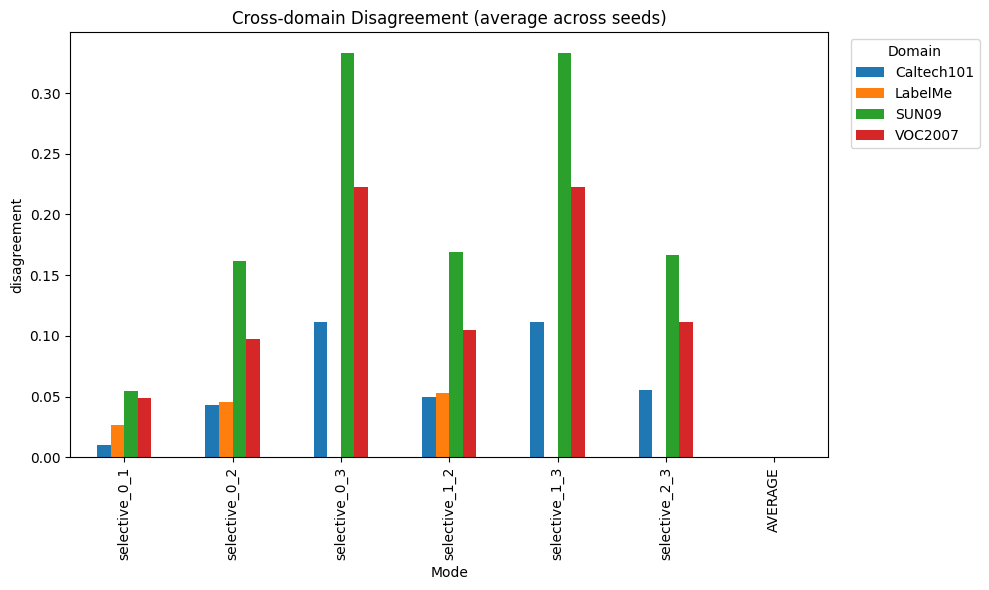

In [4]:
FILE_PATH = Path("vlcs_tta_results_all_domains_20250820_115337.txt")

# ---------- Parsing-Helper ----------
domain_header_re = re.compile(r"^=== TEST DOMAIN:\s+([A-Za-z0-9_]+)\s+===", re.MULTILINE)
mode_header_re = re.compile(r"^Mode:\s+([A-Z]+(?:_\d+){1,3})\s*$", re.MULTILINE)
seed_re = re.compile(r"^Seed:\s+\d+\s*$", re.MULTILINE)
# In einem Seed-Block (typischerweise nach "Cross-domain summary") diese beiden Metriken extrahieren
mean_real_class_var_re = re.compile(r"Mean real class variance:\s+([0-9]*\.?[0-9]+)")
mean_cross_domain_disagr_re = re.compile(r"Mean cross-domain disagreement:\s+([0-9]*\.?[0-9]+)")

text = FILE_PATH.read_text(encoding="utf-8", errors="ignore")

# Domänen-Sektionen finden
domains = []
for m in domain_header_re.finditer(text):
    domains.append((m.group(1), m.start()))

# End-Sentinel hinzufügen und Blöcke schneiden
domains_with_bounds = []
for i, (dom, start) in enumerate(domains):
    end = domains[i+1][1] if i+1 < len(domains) else len(text)
    domains_with_bounds.append((dom, text[start:end]))

# Datenstruktur: {(domain, mode): list of (real_class_var, disagreement) pro Seed}
data = defaultdict(list)
#modes_wanted = {"SINGLE_0", "SINGLE_1", "SINGLE_2", "SINGLE_3"}
modes_wanted = {"SELECTIVE_0_1", "SELECTIVE_0_2", "SELECTIVE_0_3", "SELECTIVE_1_2", "SELECTIVE_1_3", "SELECTIVE_2_3", "AVERAGE"}

for dom, dom_block in domains_with_bounds:
    # Alle SINGLE_X-Mode-Blöcke in dieser Domain
    for mode_match in mode_header_re.finditer(dom_block):
        mode = mode_match.group(1)
        if mode not in modes_wanted:
            continue
        mode_start = mode_match.end()
        next_mode_match = mode_header_re.search(dom_block, mode_start)
        mode_block = dom_block[mode_start: next_mode_match.start()] if next_mode_match else dom_block[mode_start:]
        
        # Seeds im Mode-Block iterieren
        seed_positions = list(seed_re.finditer(mode_block))
        if not seed_positions:
            continue
        for si, sm in enumerate(seed_positions):
            s_start = sm.end()
            s_end = seed_positions[si+1].start() if si+1 < len(seed_positions) else len(mode_block)
            seed_block = mode_block[s_start:s_end]
            
            # Metriken im Seed-Block finden
            var_m = mean_real_class_var_re.search(seed_block)
            dis_m = mean_cross_domain_disagr_re.search(seed_block)
            if var_m and dis_m:
                real_class_var = float(var_m.group(1))
                disagreement = float(dis_m.group(1))
                data[(dom, mode)].append((real_class_var, disagreement))

# Über Seeds mitteln
rows = []
for (dom, mode), lst in sorted(data.items()):
    if not lst:
        continue
    mean_var = sum(v for v, d in lst) / len(lst)
    mean_dis = sum(d for v, d in lst) / len(lst)
    rows.append({
        "domain": dom,
        "mode": mode,
        "mean_real_class_variance": mean_var,
        "mean_disagreement": mean_dis
    })

df = pd.DataFrame(rows)

# Nur gewünschte Modes
#mode_order = ["SINGLE_0", "SINGLE_1", "SINGLE_2", "SINGLE_3"]
mode_order = ["SELECTIVE_0_1", "SELECTIVE_0_2", "SELECTIVE_0_3", "SELECTIVE_1_2", "SELECTIVE_1_3", "SELECTIVE_2_3", "AVERAGE"]
df = df[df["mode"].isin(mode_order)].copy()

# Labels für Domains und Modes
#domain_label_map = {
 #   "ART_PAINTING": "Art Painting",
  #  "CARTOON": "Cartoon",
   # "PHOTO": "Photo",
    #"SKETCH": "Sketch",
#}
domain_label_map = {
    "CALTECH101": "Caltech101",
    "LABELME": "LabelMe",
    "SUN09": "SUN09",
    "VOC2007": "VOC2007"
}
#mode_label_map = {m: m.replace("SINGLE_", "single_") for m in mode_order}
mode_label_map = {m: m.replace("SELECTIVE_", "selective_") for m in mode_order}

df["domain_label"] = df["domain"].map(domain_label_map).fillna(df["domain"].str.title())
df["mode_label"] = df["mode"].map(mode_label_map)

# Pivot für die Plots
var_pivot = df.pivot(index="mode_label", columns="domain_label",
                     values="mean_real_class_variance").reindex(mode_label_map.values())
dis_pivot = df.pivot(index="mode_label", columns="domain_label",
                     values="mean_disagreement").reindex(mode_label_map.values())

# Optional: Tabellen anzeigen
print("Durchschnittliche (real) Klassenvarianz pro Mode und Domain:")
display(var_pivot.round(4))
print("\nDurchschnittliches (cross-domain) Disagreement pro Mode und Domain:")
display(dis_pivot.round(4))

# ---------- Plotten ----------
# Matplotlib: je Plot eine Figure, keine Styles/Colors explizit gesetzt.

# (1) (Real) Klassenvarianz
ax = var_pivot.plot(kind="bar", figsize=(10, 6))
ax.set_title("Class variance (average across seeds)")
ax.set_xlabel("Mode")
ax.set_ylabel("class variance")
ax.legend(title="Domain", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig("class_variance.png")
plt.show()

# (2) Cross-domain Disagreement
ax = dis_pivot.plot(kind="bar", figsize=(10, 6))
ax.set_title("Cross-domain Disagreement (average across seeds)")
ax.set_xlabel("Mode")
ax.set_ylabel("disagreement")
ax.legend(title="Domain", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig("disagreement.png")
plt.show()

**Pearsons Correlation**

In [6]:
# pacs

acc = {
    "single_0": {"Art Painting": 86.83, "Cartoon": 76.46, "Photo": 97.11, "Sketch": 72.74},
    "single_1": {"Art Painting": 87.47, "Cartoon": 79.57, "Photo": 96.86, "Sketch": 78.80},
    "single_2": {"Art Painting": 83.06, "Cartoon": 79.10, "Photo": 95.93, "Sketch": 71.49},
    "single_3": {"Art Painting": 13.51, "Cartoon": 15.95, "Photo": 15.04, "Sketch": 11.98},
    "selective_0_1": {"Art Painting": 86.94, "Cartoon": 78.71, "Photo": 96.69, "Sketch": 77.16},
    "selective_0_2": {"Art Painting": 83.45, "Cartoon": 79.41, "Photo": 95.48, "Sketch": 72.84},
    "selective_0_3": {"Art Painting": 13.51, "Cartoon": 15.95, "Photo": 15.04, "Sketch": 11.98},
    "selective_1_2": {"Art Painting": 82.77, "Cartoon": 79.45, "Photo": 94.98, "Sketch": 73.19},
    "selective_1_3": {"Art Painting": 13.51, "Cartoon": 15.95, "Photo": 15.04, "Sketch": 11.98},
    "selective_2_3": {"Art Painting": 13.51, "Cartoon": 15.95, "Photo": 15.04, "Sketch": 11.98}
}

var = {
    "single_0": {"Art Painting": 0.0098, "Cartoon": 0.0081, "Photo": 0.0025, "Sketch": 0.0101},
    "single_1": {"Art Painting": 0.0084, "Cartoon": 0.0075, "Photo": 0.0026, "Sketch": 0.0090},
    "single_2": {"Art Painting": 0.0112, "Cartoon": 0.0144, "Photo": 0.0043, "Sketch": 0.0125},
    "single_3": {"Art Painting": 0.0313, "Cartoon": 0.0400, "Photo": 0.0430, "Sketch": 0.0116},
    "selective_0_1": {"Art Painting": 0.0113, "Cartoon": 0.0103, "Photo": 0.0034, "Sketch": 0.0117},
    "selective_0_2": {"Art Painting": 0.0175, "Cartoon": 0.0181, "Photo": 0.0064, "Sketch": 0.0234},
    "selective_0_3": {"Art Painting": 0.0313, "Cartoon": 0.0400, "Photo": 0.0430, "Sketch": 0.0116},
    "selective_1_2": {"Art Painting": 0.0156, "Cartoon": 0.0187, "Photo": 0.0064, "Sketch": 0.0173},
    "selective_1_3": {"Art Painting": 0.0313, "Cartoon": 0.0400, "Photo": 0.0430, "Sketch": 0.0116},
    "selective_2_3": {"Art Painting": 0.0156, "Cartoon": 0.0200, "Photo": 0.0215, "Sketch": 0.0058},
}

In [8]:
# vlcs

acc = {
    "single_0": {"Caltech101": 97.6, "LabelMe": 63.28, "SUN09": 70.28, "VOC2007": 77.02},
    "single_1": {"Caltech101": 96.51, "LabelMe": 63.79, "SUN09": 70.13, "VOC2007": 77.08},
    "single_2": {"Caltech101": 90.15, "LabelMe": 62.73, "SUN09": 61.20, "VOC2007": 70.06},
    "single_3": {"Caltech101": 55.62, "LabelMe": 46.57, "SUN09": 35.14, "VOC2007": 39.14},
    "selective_0_1": {"Caltech101": 95.78, "LabelMe": 63.22, "SUN09": 69.60, "VOC2007": 76.45},
    "selective_0_2": {"Caltech101": 88.21, "LabelMe": 61.21, "SUN09": 58.94, "VOC2007": 67.76},
    "selective_0_3": {"Caltech101": 55.62, "LabelMe": 46.57, "SUN09": 35.14, "VOC2007": 39.14},
    "selective_1_2": {"Caltech101": 86.23, "LabelMe": 61.67, "SUN09": 58.00, "VOC2007": 66.68},
    "selective_1_3": {"Caltech101": 55.62, "LabelMe": 46.57, "SUN09": 35.14, "VOC2007": 39.14},
    "selective_2_3": {"Caltech101": 55.62, "LabelMe": 46.57, "SUN09": 35.14, "VOC2007": 39.14},
    # "average" and "Baseline" omitted (no variance values given)
}

var = {
    "single_0": {"Caltech101": 0.0002, "LabelMe": 0.0028, "SUN09": 0.0051, "VOC2007": 0.0051},
    "single_1": {"Caltech101": 0.0008, "LabelMe": 0.0047, "SUN09": 0.0074, "VOC2007": 0.0066},
    "single_2": {"Caltech101": 0.0052, "LabelMe": 0.0056, "SUN09": 0.0270, "VOC2007": 0.0168},
    "single_3": {"Caltech101": 0.0110, "LabelMe": 0.0098, "SUN09": 0.0473, "VOC2007": 0.0346},
    "selective_0_1": {"Caltech101": 0.0011, "LabelMe": 0.0060, "SUN09": 0.0100, "VOC2007": 0.0080},
    "selective_0_2": {"Caltech101": 0.0054, "LabelMe": 0.0090, "SUN09": 0.0298, "VOC2007": 0.0192},
    "selective_0_3": {"Caltech101": 0.0110, "LabelMe": 0.0098, "SUN09": 0.0473, "VOC2007": 0.0346},
    "selective_1_2": {"Caltech101": 0.0061, "LabelMe": 0.0116, "SUN09": 0.0311, "VOC2007": 0.0217},
    "selective_1_3": {"Caltech101": 0.0110, "LabelMe": 0.0098, "SUN09": 0.0473, "VOC2007": 0.0346},
    "selective_2_3": {"Caltech101": 0.0055, "LabelMe": 0.0050, "SUN09": 0.0237, "VOC2007": 0.0173},
}


Overall Pearson r (accuracy vs. variance): -0.6905
Caltech101: r = -0.8681
LabelMe: r = -0.4098
SUN09: r = -0.8475
VOC2007: r = -0.8533


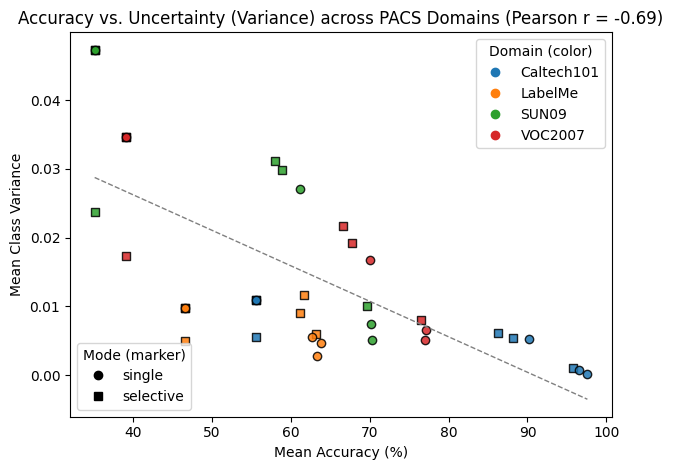

In [9]:
rows = []
for mode, dom_dict in acc.items():
    if mode not in var:
        continue
    for domain, acc_val in dom_dict.items():
        if domain not in var[mode]:
            continue
        rows.append({
            "mode": mode,
            "strategy": "single" if mode.startswith("single") else "selective",
            "domain": domain,
            "accuracy": float(acc_val),
            "variance": float(var[mode][domain]),
        })

df = pd.DataFrame(rows).sort_values(["domain", "mode"]).reset_index(drop=True)

# 2) Pearson correlation (overall and per domain) using numpy (no SciPy dependency)
def safe_pearson(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if len(x) < 2 or np.allclose(np.std(x), 0) or np.allclose(np.std(y), 0):
        return np.nan
    return np.corrcoef(x, y)[0, 1]

overall_r = safe_pearson(df["accuracy"], df["variance"])
print("Overall Pearson r (accuracy vs. variance):", np.round(overall_r, 4))

per_domain_r = {}
for dom, sub in df.groupby("domain"):
    r = safe_pearson(sub["accuracy"], sub["variance"])
    per_domain_r[dom] = r
    print(f"{dom}: r = {np.round(r, 4)}")

# 3) Plot: domain=color, strategy=marker; add global least-squares line
marker_map = {"single": "o", "selective": "s"}  # circle vs. square

domains = sorted(df["domain"].unique())
colors = plt.cm.tab10.colors
color_map = {dom: colors[i % len(colors)] for i, dom in enumerate(domains)}

plt.figure()

# Scatter each point with domain color and strategy marker
for _, row in df.iterrows():
    plt.scatter(
        row["accuracy"], row["variance"],
        color=color_map[row["domain"]],
        marker=marker_map[row["strategy"]],
        edgecolor="k", alpha=0.85
    )

# Global regression line: variance = a * accuracy + b
x = df["accuracy"].to_numpy()
y = df["variance"].to_numpy()
if len(x) >= 2 and not np.allclose(np.std(x), 0):
    a, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 100)
    ys = a * xs + b
    plt.plot(xs, ys, linestyle="--", linewidth=1, color="gray")

plt.xlabel("Mean Accuracy (%)")
plt.ylabel("Mean Class Variance")
plt.title(f"Accuracy vs. Uncertainty (Variance) across PACS Domains (Pearson r = {overall_r:.2f})")

# Legends: one for domain colors, one for strategy markers
domain_handles = [
    Line2D([0], [0], marker="o", color=color_map[dom], linestyle="None", label=dom)
    for dom in domains
]
strategy_handles = [
    Line2D([0], [0], marker=marker_map["single"], color="black", linestyle="None", label="single"),
    Line2D([0], [0], marker=marker_map["selective"], color="black", linestyle="None", label="selective"),
]

legend1 = plt.legend(handles=domain_handles, title="Domain (color)", loc="upper right")
plt.gca().add_artist(legend1)
plt.legend(handles=strategy_handles, title="Mode (marker)", loc="lower left")

plt.tight_layout()
plt.savefig("vlcs_correlation.png")
plt.show()

In [11]:
r_overall, p_overall = pearsonr(df["accuracy"], df["variance"])
print(f"Overall Pearson r = {r_overall:.3f}, p = {p_overall:.4f}")

# Per-domain correlations with p-values
for dom, sub in df.groupby("domain"):
    r, p = pearsonr(sub["accuracy"], sub["variance"])
    print(f"{dom}: r = {r:.4f}, p = {p:.4f}")

Overall Pearson r = -0.691, p = 0.0000
Caltech101: r = -0.8681, p = 0.0011
LabelMe: r = -0.4098, p = 0.2395
SUN09: r = -0.8475, p = 0.0020
VOC2007: r = -0.8533, p = 0.0017


Loaded 528 accuracies and 396 variances


/tmp/ipykernel_4041677/3686439196.py:30: RuntimeWarning: Mean of empty slice.
  curr_acc = accuracies_raw[curr_ids].mean()  # average over remaining
/home/hahlers/miniconda3/envs/server_env/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


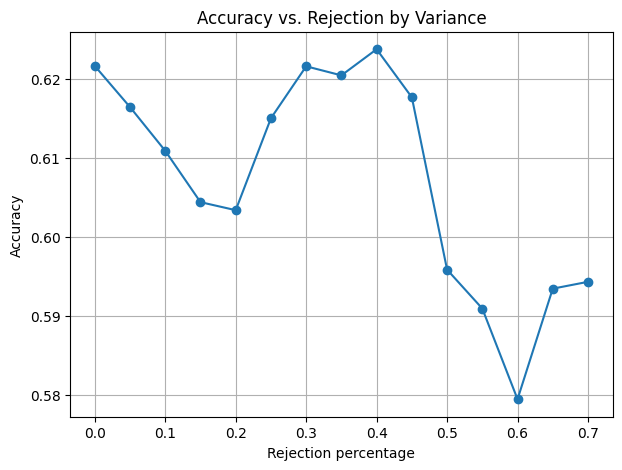

In [12]:
path = "pacs_tta_results_all_domains_20250820_115822.txt"

# Read file
with open(path, "r") as f:
    text = f.read()

# Extract accuracies and variances from lines like:
# "Accuracy: 0.8730"
# "Real class variance: 0.0869"
acc_pattern = re.compile(r"Accuracy:\s+([0-9.]+)")
var_pattern = re.compile(r"Real class variance:\s+([0-9.]+)")

accuracies_raw = [float(x) for x in acc_pattern.findall(text)]
variances_raw = [float(x) for x in var_pattern.findall(text)]

# Turn into numpy arrays
accuracies_raw = np.array(accuracies_raw)
variances_raw = np.array(variances_raw)

print(f"Loaded {len(accuracies_raw)} accuracies and {len(variances_raw)} variances")

# ---- Rejection curve computation ----
sorted_ids = np.argsort(variances_raw)  # lowest variance = most certain
rejection_percentages = np.linspace(0, 1.0, 21)  # 0%, 5%, ... 100%
accuracies = []

for rp in rejection_percentages:
    size = int(len(accuracies_raw) * rp)
    curr_ids = sorted_ids[size:]  # remove most uncertain ones
    curr_acc = accuracies_raw[curr_ids].mean()  # average over remaining
    accuracies.append(curr_acc)

# ---- Plot ----
plt.figure(figsize=(7,5))
plt.plot(rejection_percentages, accuracies, marker="o")
plt.xlabel("Rejection percentage")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Rejection by Variance")
plt.grid(True)
plt.show()